In [1]:
#Import Dependecies

import warnings
warnings.filterwarnings('ignore')

#PER
from Memory import *


# Keras and TF
import keras.backend.tensorflow_backend as backend
from keras.models import Sequential
from keras.layers import Input, Dense, Dropout, Conv2D, MaxPooling2D, Activation, Flatten, concatenate
from keras.layers.normalization import BatchNormalization

from keras.optimizers import Adam
from keras.callbacks import TensorBoard

import tensorflow as tf

#Misc
from collections import deque
import time
import traci
from datetime import datetime

import random
from tqdm import tqdm


import os 
os.environ['CUDA_DEVICE_ORDER'] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]=""

import random 
import numpy as np
from collections import deque

import numpy as np
import matplotlib.pyplot as plt
import pickle

#SUMO TraCI
import traci




Using TensorFlow backend.


In [2]:
#Get Multiple types of states : 

def get_state(intersection, state_type ='n_of_vehicles', edge_length=750, max_pos=250, in_out=False,\
              get_reward=False, ignore_far_cars=False):
    '''
    Retrieve Different Types of states specified by state_type,
    Default: n_of_vehicles. specify the horizon of detection by max_pos.
    choose from: queue, waiting_time, throughput, queue_in_out, throughput, speed, fuel_consumption.
    Output: Vector including lane states, and current phase state [0,1,2,3]. 
    '''
    # retrieve incoming lanes list of the traffic light 
    lanes_list = list(traci.trafficlight.getControlledLanes(intersection))
    # Outgoing list from the intersection
    out_list = [lane.replace('in','out') for lane in lanes_list]
    if in_out:
        lanes_list+= out_list
    N = len(lanes_list) 
    state = np.zeros((N+1 ,1), dtype=np.int32)
    
    # Troughput
    if state_type == 'throughput':
        for i,lane in enumerate(out_list): 
            veh_count = 0
            for vehicle in traci.lane.getLastStepVehicleIDs(lane): # loop over vehicles in lane

                veh_pos = traci.vehicle.getLanePosition(vehicle) # get vehicle's position
                if veh_pos <max_pos:
                    veh_count+=1
            state[i] = veh_count
      
    #Queue In and throughput
    elif state_type == 'queue_in_out':
        N = len(lanes_list) + len(out_list)
        state = np.zeros((N+1, 1), dtype=np.int32)
        
        for i,lane in enumerate(lanes_list):
            
            lane_state = traci.lane.getLastStepHaltingNumber(lanes_list[i]) #get number of
                                                                            #halting vehicles on a given lane

            
        for i,lane in enumerate(out_list): 
            veh_count = 0
            for vehicle in traci.lane.getLastStepVehicleIDs(lane): # loop over vehicle iDs in lane

                veh_pos = traci.vehicle.getLanePosition(vehicle) # get vehicle's position
                if veh_pos <max_pos:
                    veh_count+=1
            state[i+len(lanes_list)] = veh_count
            
    else:
#         car_list = traci.vehicle.getIDList()
        for i,lane in enumerate(lanes_list):
            
            # queue state
            if state_type == 'queue':
                lane_state = traci.lane.getLastStepHaltingNumber(lanes_list[i])#get number of Queuing/
                                                                            #halting vehicles on lane
                state[i] = lane_state
           
            
            #waiting time state 
            elif state_type == 'waiting_time':
                lane_state = traci.lane.getWaitingTime(lanes_list[i]) # get waiting vehicles on lane
                
                state[i] = lane_state
            # Alternative waiting time state 
            elif state_type == 'waiting_time_2':
                lane_state = 0

                for car_id in traci.lane.getLastStepVehicleIDs(lane):# loop over vehicle iDs in lane
                    wait_time = traci.vehicle.getWaitingTime(car_id) # get waiting time of the vehicle
                    lane_id = traci.vehicle.getLaneID(car_id)  # lane id of the car
                    if lane_id == lane:  # add waiting time of vehicles to the corresponding lane.
                        lane_state += wait_time
                
                state[i] = lane_state
            
            
            # Speed state
            elif state_type == 'speed':  
                lane_state = traci.lane.getLastStepMeanSpeed(lanes_list[i]) # Get average speed of vehicles
                                                                            # on the given lane
                state[i] = lane_state
            
            # Alternative waiting time state
            elif state_type == 'n_of_vehicles_2':                
                    for car_id in traci.lane.getLastStepVehicleIDs(lane):
                        lane_id = traci.vehicle.getLaneID(car_id)
                        if lane_id == lane:  
                            state[i] += 1
            # Alternative waiting time state
            elif state_type == 'n_of_vehicles_3':
                lane_state = traci.lane.getLastStepVehicleNumber(lanes_list[i])
                state[i] = lane_state
            
            # Fuel consumption
            elif state_type == 'fuel_consumption':
                lane_state = traci.lane.getFuelConsumption(lanes_list[i])
                state[i] = lane_state
                
            #else Number of Vehicles State. Default 
            else:

                lane_state = traci.lane.getLastStepVehicleNumber(lanes_list[i])

                lane_approach = 0
                veh_count = 0
                for vehicle in traci.lane.getLastStepVehicleIDs(lane):

                    if lane not in out_list:

                        veh_pos = (edge_length-17) - np.abs(int(traci.vehicle.getLanePosition(vehicle)))
                        if veh_pos<7:
                            lane_approach=1

                        if veh_pos <max_pos:


                            veh_count+=1

#                     if lane in out_list:
#                         veh_pos = traci.vehicle.getLanePosition(vehicle)
#                         if veh_pos <max_pos:
#                             veh_count+=1

                if ignore_far_cars:
                    lane_approach = lane_approach
                else:
                    lane_approach = 1

                if lane_approach:
                    state[i] = veh_count
   
    # if retrieving just the reward value, not state vector.
    if get_reward:
        reward = np.sum(np.array(state))
        return reward
    #else, we proceed with adding the state current phase to the state vector
    else:
        all_phases = traci.trafficlight.getAllProgramLogics(intersection) # get all phases codings from
                                                                            #traffic light control id
        current_phase = traci.trafficlight.getRedYellowGreenState(intersection) # get the current phase of signals
    
        # Encode the current phase to either 0 or 1 or 2 or 3
        for i,phase in enumerate(all_phases[0].getPhases()):
            s = phase.__repr__().split(',')
            s = s[1].split('\'')[1]

#             pure_phases.append(s)
            if current_phase == s:
                state[N] = np.floor(i/2)

        return state

In [3]:

            
# Get the number of outgoing vehicles 
def get_queue_out(intersection, max_pos=250):
    lanes_list = list(traci.trafficlight.getControlledLanes(intersection))
    #     all_lane_list = traci.lane.getIDList()
    out_list = [lane.replace('in','out') for lane in lanes_list]
    queue_list = []

    for lane in out_list:
        veh_count = 0
        for vehicle in traci.lane.getLastStepVehicleIDs(lane):

            veh_pos = traci.vehicle.getLanePosition(vehicle)
            if veh_pos < max_pos:
                veh_count+=1

        queue_list.append(veh_count)

    queue = np.sum(np.asarray(queue_list))
    return queue


       
# Get the total number of queuing vehicles at the intersection
    
def get_queue(intersection):
    lanes_list = list(traci.trafficlight.getControlledLanes(intersection))
    queue_list = []
    for lane in lanes_list:
        q = traci.lane.getLastStepHaltingNumber(lane)
        queue_list.append(q)
    
    queue = np.sum(np.asarray(queue_list))
    
    return queue



    

In [4]:
# Utils 

# freeze the simulation, step forward without executing new actions.
def freeze(steps):
    '''
    freeze the simulation, step forward without executing new actions.
    '''
    #replace later by self.step_counter
    for step in range(steps):
        traci.simulationStep()
        #update step counter
        
# choose action according to epsilon-greedy policy
def choose_action(model, state):
    '''
    choose action according to epsilon-greedy policy
    '''
    if np.random.random < epsilon:
        action = np.radnom.choice(action_space)
        
    else:
        action = model.predict(state)
    return action

# choose a random action 
def random_action(action_size=4):
    '''choose a random action '''
    action_size = 4 
    action = action = random.randrange(action_size)
    return action

# set Green phase with the specified duration for the given traffic light
def set_green_phase(action, green_duration=15, intersection='intersection'):
    '''
    set Green phase with the specified duration for the given traffic light
    '''
    act = action
    green_phase_code = action * 2
    for t in range(green_duration):
        
        traci.trafficlight.setPhase(intersection, green_phase_code)
        traci.simulationStep()
    
    
# set Yellow phase with the specified duration for the given traffic light
def set_yellow_phase(action, yellow_duration=3, intersection='intersection'):
    '''
    set Yellow phase with the specified duration for the given traffic light
    '''
    yellow_phase_code = action * 2 + 1
    for t in range(yellow_duration):
        
        traci.trafficlight.setPhase(intersection, yellow_phase_code)
        traci.simulationStep()

In [5]:
# #uncomment to verify the inface with sumo and make sure everything is working

# sumoBinary = 'sumo-gui'

# options = ["--time-to-teleport","-1","--statistic-output","stats.xml", "--eager-insert","True", \
#            "--tripinfo-output","intersection_3_info.xml","--summary-output","summary.xml",\
#            "--tripinfo-output.write-unfinished","True"]
# sumoCmd = [sumoBinary,"-c","intersection_3.sumocfg",*options]

# traci.start(sumoCmd)
# intersection = 'intersection'
# step = 0
# traci.simulationStep()
# queue_list = []
# flow_list = np.zeros((16))
# while step<3800:

#     traci.simulationStep()
#     step = step + 1
    
# # #     reward = get_lanes_waiting_time(intersection)
# #     if step % 36 == 0 :
# #         print(step)
# #         print(get_state(intersection))
# #         print(action_id)
# #     print(traci.trafficlight.get)
# #     print('w_t1:',reward, 'w_t2:',get_total_waiting_time())
# #     flow_list += np.array(get_flow())
# #     state = get_state(intersection = intersection)
# #     a = datetime.now()
# #     queue_list.append(get_queue(intersection))
# #     state = get_state(intersection = intersection, state_type='n_of_vehicles')
# #     b = datetime.now()
# #     print('complex method', b-a)

# #     state2 = get_state(intersection = intersection, state_type='waiting_time_2')
# #     print('simple method', datetime.now() - b)
# #     print(state)
# #     print(state2)
# #         flow_list = np.zeros((16))
# #     print('flow', get_total_flow(intersection, interval=10))
    
    
# #for each episode





# traci.close()


In [6]:
#Extra

#Reading values for travel time list for all vehicles from the trip info generated file

def get_from_info(file_path='intersection_3_info.xml',retrieve='duration'):
    retrieve = ' '+ retrieve +'='

    '''
    Reading values for travel time list for all vehicles from the trip info generated file
    can retrieve other information specified by the retrieve paramter, ex: waitingTime
    '''
    duration_list = []

    with open(file_path,'r') as f:
        text_lines = f.readlines()
        for w in text_lines:
            a = w.split('"')
            for i,value in enumerate(a):

                if value==retrieve:
                    
                    duration_list.append(a[i+1])
    
    return duration_list


def get_lanes_waiting_time(intersection):
    
    lanes_list = list(traci.trafficlight.getControlledLanes(intersection))
    
    waiting_time_list = []
    
    for lane in lanes_list:
        time = traci.lane.getWaitingTime(lane)
        waiting_time_list.append(time)
        
    t_waiting_time = np.sum(np.asarray(waiting_time_list))
    
    return t_waiting_time
    
    
#get current waiting time of a cars, Not accumulated waiting time



def get_consecutive_waiting_time(intersection='intersection'):
    '''total current waiting time in seconds'''
    
    lanes_list = list(traci.trafficlight.getControlledLanes(intersection))
    N = len(lanes_list)
    state = np.zeros((N,1), dtype=np.int32)
   
            
    car_list = traci.vehicle.getIDList()
    for i, lane in enumerate(lanes_list):
        lane_state = 0
        for car_id in car_list:
            wait_time = traci.vehicle.getWaitingTime(car_id)
            lane_id = traci.vehicle.getLaneID(car_id) 
            if lane_id == lane:  
                lane_state += wait_time
        
        state[i] = lane_state
    return state
    
def get_total_waiting_time():
    '''total current waiting time in seconds'''
    wt = {}
    incoming_roads = ["e1_in", "e2_in", "e3_in", "e4_in"]
    car_list = traci.vehicle.getIDList()
    for car_id in car_list:
        wait_time = traci.vehicle.getWaitingTime(car_id)
        road_id = traci.vehicle.getRoadID(car_id)  # get the road id where the car is located
        if road_id in incoming_roads:  # consider only the waiting times of cars in incoming roads
            wt[car_id] = wait_time
        else:
            if car_id in wt: # a car that was tracked has cleared the intersection
                del wt[car_id] 
    waiting_time = sum(wt.values())
    return waiting_time, wt
#get Average Waiting time for a car

def get_total_accumulated_waiting_time():
    '''total accumulated waiting time over 100 seconds'''
    wt = {}
    incoming_roads = ["e1_in", "e2_in", "e3_in", "e4_in"]
    car_list = traci.vehicle.getIDList()
    for car_id in car_list:
        wait_time = traci.vehicle.getAccumulatedWaitingTime(car_id)
        road_id = traci.vehicle.getRoadID(car_id)  # get the road id where the car is located
        if road_id in incoming_roads:  # consider only the waiting times of cars in incoming roads
            wt[car_id] = wait_time
        else:
            if car_id in wt: # a car that was tracked has cleared the intersection
                del wt[car_id] 
    total_accumulated_waiting_time = sum(wt.values())
    return total_accumulated_waiting_time, wt


    

In [7]:
#VIZ



def plot_and_save(data, out_dir, file_name, save=True,save_data=True, font_size=12, font_weight='bold', x_label='Episode', y_label='y',  style='seaborn-whitegrid',\
                  episode=0, smoothing=True, smoothing_window=10, fig_size=(14,10), c='c', plot=True,
                   ):
    if save_data:
        save_score_file(data, out_dir=out_dir, file_name=file_name)
        
    plt.style.use(style)
    if smoothing:
        data = smoothing_curve(data,smoothing_window)
    
    font = {'family' : 'normal',
        'weight' : font_weight,
        'size'   : font_size}

    plt.rc('font', **font)
#     plt.rcParams.update({'font.size':14, })
    x = [i for i in range(len(data))]
    fig1 = plt.figure(figsize=fig_size)
    plt.plot(x, data, c)
    plt.xlabel(x_label)
    plt.ylabel(file_name)
    if save:
        plt.savefig(out_dir + '/'+ file_name+ str(episode)+f'{episode}.png')
    
def smoothing_curve(array, window_length=10):
    smoothened = []
    for i in range(1,len(array)):
        
        x = sum(array[:i][-window_length:])/len(array[:i][-window_length:])
        smoothened.append(x)
    return smoothened
    
    
# plot_and_save(queue_list, model_path, 'Queue', smoothing_window=10)

def save_score_file(data, out_dir='scores_data', file_name='scores'):
    if not os.path.exists(out_dir):
        os.makedirs(out_dir)
        
    file_path  = os.path.join(out_dir, file_name +'.txt')
    
    with open(file_path, 'w') as f:
        for d in data:
            f.write(str(d)+'\n')
            
# save_score_file(a,'testing_out_scores' )

def get_score_file(file_path):
    out_list = []
    with open(file_path, 'r') as f:
        for line in f:
            line = line.replace('\n','')
            n = int(float(line))
            out_list.append(n)
  
    return out_list       

In [8]:
# # Generate Route File with random distribution 

# def generate_route_file(dist = 'weibull', n_steps=3600, n_cars_1=1500, n_cars_2=4000, n_cars_3 = 1500,\
#                         mu=2000, sigma=1000, episode=1, o_file="intersection_3.rou.xml"):
#     r = np.random.RandomState(episode)
#     if dist=='weibull':
#         s_1 = r.weibull(2, n_cars_1)
#         mins_1 = min(s_1)
#         maxs_1 = max(s_1)
#         new_s_1 = []
#         for v in s_1:
#             v = v*n_steps/(maxs_1-mins_1)
#             new_s_1.append(v)
#         s_1=new_s_1
        
#         if n_cars_2:
#             s_2 = r.weibull(2, n_cars_2)
#             mins_2 = min(s_2)
#             maxs_2 = max(s_2)
#             new_s_2 = []
#             for v in s_2:
#                 v = v*n_steps/(maxs_2-mins_2)
#                 new_s_2.append(v)
#             s_2=new_s_2
        
#         if n_cars_3:
#             s_3 = r.weibull(2, n_cars_3)
#             mins_3 = min(s_3)
#             maxs_3 = max(s_3)
#             new_s_3 = []
#             for v in s_3:
#                 v = v*n_steps/(maxs_3-mins_3)
#                 new_s_3.append(v)
#             s_3=new_s_3
    
#     else:
#         s_1 = r.normal(mu, sigma, n_cars_1)
#         if n_cars_2:
#             s_2 = r.normal(mu, sigma, n_cars_2)
#         if n_cars_3:
#             s_3 = r.normal(mu, sigma, n_cars_3)
    
#     s_1 = np.abs(np.rint(s_1))
#     s_1 = sorted(s_1)
    
#     max_s_1 = max(s_1)
# #     print(max_s_1)
#     if n_cars_2:
#         s_2 = np.abs(np.rint(s_2))
#         s_2 = sorted(s_2)
#         for e in s_2:
#             e = e + max_s_1
#             s_1.append(e)
    
#     max_s_1 = max(s_1)
#     if n_cars_3:
#         s_3 = np.abs(np.rint(s_3))
#         s_3 = sorted(s_3)
#         for e in s_3:
#             e = e + max_s_1
#             s_1.append(e)
    
# #     print(s_2[100:120])
# #     print(s_1[4500:4520])
#     s = s_1
#     with open(o_file, "w") as routes:
#         print('<routes>', file=routes)
#         for car_id, t in enumerate(s):
#             if np.random.uniform()<0.75:
#                 route_id = np.random.randint(1, 5)  
#                 if route_id == 1:
#                     print(f'      <vehicle id="{car_id}" depart="{t}"> \n        <route edges="e1_in e3_out"/> \n      </vehicle>',file=routes)
#                 elif route_id ==2 :
#                     print(f'      <vehicle id="{car_id}" depart="{t}"> \n        <route edges="e2_in e4_out"/> \n      </vehicle>',file=routes)
#                 elif route_id ==3:
#                     print(f'      <vehicle id="{car_id}" depart="{t}"> \n        <route edges="e3_in e1_out"/> \n      </vehicle>',file=routes)
#                 elif route_id ==4:
#                     print(f'      <vehicle id="{car_id}" depart="{t}"> \n        <route edges="e4_in e2_out"/> \n      </vehicle>',file=routes)

#             else:
#                 if np.random.uniform()<0.5:
                    
#                     route_id = np.random.randint(1, 5)  
#                     if route_id == 1:
#                         print(f'      <vehicle id="{car_id}" depart="{t}"> \n        <route edges="e1_in e4_out"/> \n      </vehicle>',file=routes)
#                     elif route_id ==2 :
#                         print(f'      <vehicle id="{car_id}" depart="{t}"> \n        <route edges="e2_in e1_out"/> \n      </vehicle>',file=routes)
#                     elif route_id ==3:
#                         print(f'      <vehicle id="{car_id}" depart="{t}"> \n        <route edges="e3_in e2_out"/> \n      </vehicle>',file=routes)
#                     elif route_id ==4:
#                         print(f'      <vehicle id="{car_id}" depart="{t}"> \n        <route edges="e4_in e3_out"/> \n      </vehicle>',file=routes)

#                 else:
#                     route_id = np.random.randint(1, 5)  
#                     if route_id == 1:
#                         print(f'      <vehicle id="{car_id}" depart="{t}"> \n        <route edges="e1_in e2_out"/> \n      </vehicle>',file=routes)
#                     elif route_id ==2 :
#                         print(f'      <vehicle id="{car_id}" depart="{t}"> \n        <route edges="e2_in e3_out"/> \n      </vehicle>',file=routes)
#                     elif route_id ==3:
#                         print(f'      <vehicle id="{car_id}" depart="{t}"> \n        <route edges="e3_in e4_out"/> \n      </vehicle>',file=routes)
#                     elif route_id ==4:
#                         print(f'      <vehicle id="{car_id}" depart="{t}"> \n        <route edges="e4_in e1_out"/> \n      </vehicle>',file=routes)


#     #         else:

#         print('</routes>', file=routes)
        
############ 2THursday ########

def generate_route_file(dist = 'weibull', n_steps_1=3600, n_steps_2=3600, n_steps_3=3600,\
                        n_cars_1=1500, n_cars_2=4000, n_cars_3 = 1500,\
                        mu=2000, sigma=1000, episode=1, o_file="intersection_3.rou.xml"):
    r = np.random.RandomState(episode)
    if dist=='weibull':
        s_1 = r.weibull(2, n_cars_1)
        mins_1 = min(s_1)
        maxs_1 = max(s_1)
        new_s_1 = []
        for v in s_1:
            v = v*n_steps_1/(maxs_1-mins_1)
            new_s_1.append(v)
        s_1=new_s_1
        
        if n_cars_2:
            s_2 = r.weibull(2, n_cars_2)
            mins_2 = min(s_2)
            maxs_2 = max(s_2)
            new_s_2 = []
            for v in s_2:
                v = v*n_steps_2/(maxs_2-mins_2)
                new_s_2.append(v)
            s_2=new_s_2
        
        if n_cars_3:
            s_3 = r.weibull(2, n_cars_3)
            mins_3 = min(s_3)
            maxs_3 = max(s_3)
            new_s_3 = []
            for v in s_3:
                v = v*n_steps_3/(maxs_3-mins_3)
                new_s_3.append(v)
            s_3=new_s_3
    
    else:
        s_1 = r.normal(mu, sigma, n_cars_1)
        if n_cars_2:
            s_2 = r.normal(mu, sigma, n_cars_2)
        if n_cars_3:
            s_3 = r.normal(mu, sigma, n_cars_3)
    
    s_1 = np.abs(np.rint(s_1))
    s_1 = sorted(s_1)
    
    max_s_1 = max(s_1)
#     print(max_s_1)
    if n_cars_2:
        s_2 = np.abs(np.rint(s_2))
        s_2 = sorted(s_2)
        for e in s_2:
            e = e + max_s_1
            s_1.append(e)
    
    max_s_1 = max(s_1)
    if n_cars_3:
        s_3 = np.abs(np.rint(s_3))
        s_3 = sorted(s_3)
        for e in s_3:
            e = e + max_s_1
            s_1.append(e)
    
#     print(s_2[100:120])
#     print(s_1[4500:4520])
    s = s_1
    with open(o_file, "w") as routes:
        print('<routes>', file=routes)
        for car_id, t in enumerate(s):
            if r.uniform()<0.75:
                route_id = r.randint(1, 5)  
                if route_id == 1:
                    print(f'      <vehicle id="{car_id}" depart="{t}"> \n        <route edges="e1_in e3_out"/> \n      </vehicle>',file=routes)
                elif route_id ==2 :
                    print(f'      <vehicle id="{car_id}" depart="{t}"> \n        <route edges="e2_in e4_out"/> \n      </vehicle>',file=routes)
                elif route_id ==3:
                    print(f'      <vehicle id="{car_id}" depart="{t}"> \n        <route edges="e3_in e1_out"/> \n      </vehicle>',file=routes)
                elif route_id ==4:
                    print(f'      <vehicle id="{car_id}" depart="{t}"> \n        <route edges="e4_in e2_out"/> \n      </vehicle>',file=routes)

            else:
                if r.uniform()<0.5:
                    
                    route_id = r.randint(1, 5)  
                    if route_id == 1:
                        print(f'      <vehicle id="{car_id}" depart="{t}"> \n        <route edges="e1_in e4_out"/> \n      </vehicle>',file=routes)
                    elif route_id ==2 :
                        print(f'      <vehicle id="{car_id}" depart="{t}"> \n        <route edges="e2_in e1_out"/> \n      </vehicle>',file=routes)
                    elif route_id ==3:
                        print(f'      <vehicle id="{car_id}" depart="{t}"> \n        <route edges="e3_in e2_out"/> \n      </vehicle>',file=routes)
                    elif route_id ==4:
                        print(f'      <vehicle id="{car_id}" depart="{t}"> \n        <route edges="e4_in e3_out"/> \n      </vehicle>',file=routes)

                else:
                    route_id = r.randint(1, 5)  
                    if route_id == 1:
                        print(f'      <vehicle id="{car_id}" depart="{t}"> \n        <route edges="e1_in e2_out"/> \n      </vehicle>',file=routes)
                    elif route_id ==2 :
                        print(f'      <vehicle id="{car_id}" depart="{t}"> \n        <route edges="e2_in e3_out"/> \n      </vehicle>',file=routes)
                    elif route_id ==3:
                        print(f'      <vehicle id="{car_id}" depart="{t}"> \n        <route edges="e3_in e4_out"/> \n      </vehicle>',file=routes)
                    elif route_id ==4:
                        print(f'      <vehicle id="{car_id}" depart="{t}"> \n        <route edges="e4_in e1_out"/> \n      </vehicle>',file=routes)


    #         else:

        print('</routes>', file=routes)

In [9]:
#Parameters:
batch_size = 32
output_dir = 'tls_model/'
AGGREGATE_STATS_EVERY = 50 

#SUMO
sumoBinary = 'sumo'
options = ["--time-to-teleport","-1","--statistic-output","stats.xml", "--eager-insert","True", \
           "--tripinfo-output","intersection_3_info.xml","--summary-output","summary.xml",\
           "--tripinfo-output.write-unfinished","False"]
sumoCmd = [sumoBinary,"-c","intersection_3.sumocfg",*options]

vehicle_set = []
lane_names = []


action_space = [0,1,2,3]
action_id = {0:'NSG',1:'EWG',2:'NSL',3:'EWL'}
NSG = 0
NSY = 1
EWG = 2
EWY = 3
NSL = 4
NSLY = 5
EWL = 6
EWLY = 7

green_duration=15
yellow_duration=3

In [10]:
import os, sys
import numpy as np
import traci

# append SUMO tools to path
if 'SUMO_HOME' in os.environ:
	tools = os.path.join(os.environ['SUMO_HOME'], 'tools')
	sys.path.append(tools)
else:
	sys.exit("please declare environment variable 'SUMO_HOME'")

    
    #if the above SUMO_HOME code doesnt work, try the next with changing the location of 
    # sumo tools

# try:
#     sys.path.append("/PATH/TO/SUMO/TOOLS/")
# except:
#     print("please declare environment variable 'SUMO_HOME'")

SystemExit: please declare environment variable 'SUMO_HOME'

[array([45.], dtype=float32), array([45.], dtype=float32), array([45.], dtype=float32), array([45.], dtype=float32)]
8
Multi-Pass P-DQN Agent
Actor Network MultiPassQActor(
  (layers): ModuleList(
    (0): Linear(in_features=21, out_features=256, bias=True)
    (1): Linear(in_features=256, out_features=4, bias=True)
  )
)
Param Network ParamActor(
  (layers): ModuleList(
    (0): Linear(in_features=17, out_features=256, bias=True)
  )
  (action_parameters_output_layer): Linear(in_features=256, out_features=4, bias=True)
  (action_parameters_passthrough_layer): Linear(in_features=17, out_features=4, bias=True)
)
Actor Alpha: 0.001
Actor Param Alpha: 1e-05
Gamma: 0.95
Tau (actor): 0.1
Tau (actor-params): 0.001
Inverting Gradients: True
Replay Memory: 20000
Batch Size: 64
Initial memory: 128
epsilon_initial: 1.0
epsilon_final: 0.01
epsilon_steps: 300
Clip Grad: 1.0
Ornstein Noise?: False
Zero Index Grads?: False
Seed: 0

['sumo', '-c', 'intersection_3.sumocfg', '--time-to-teleport', '-1',

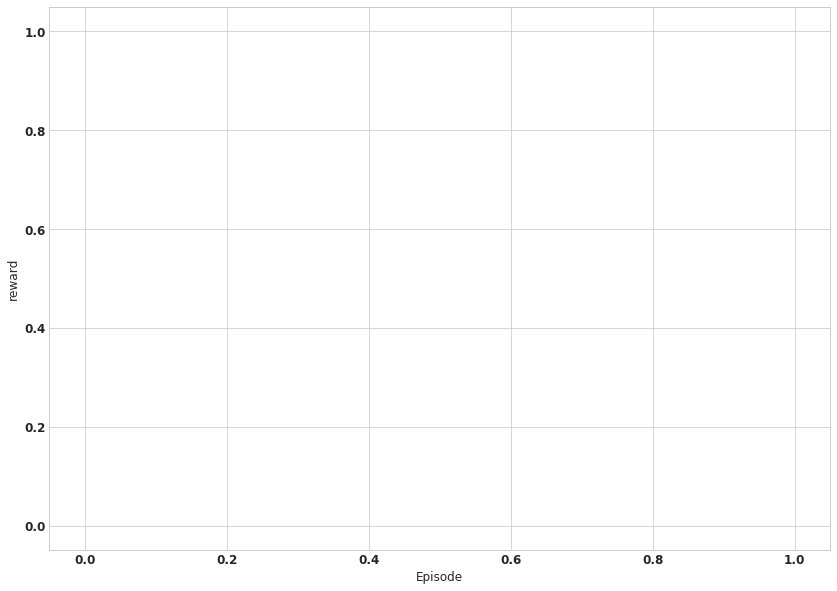

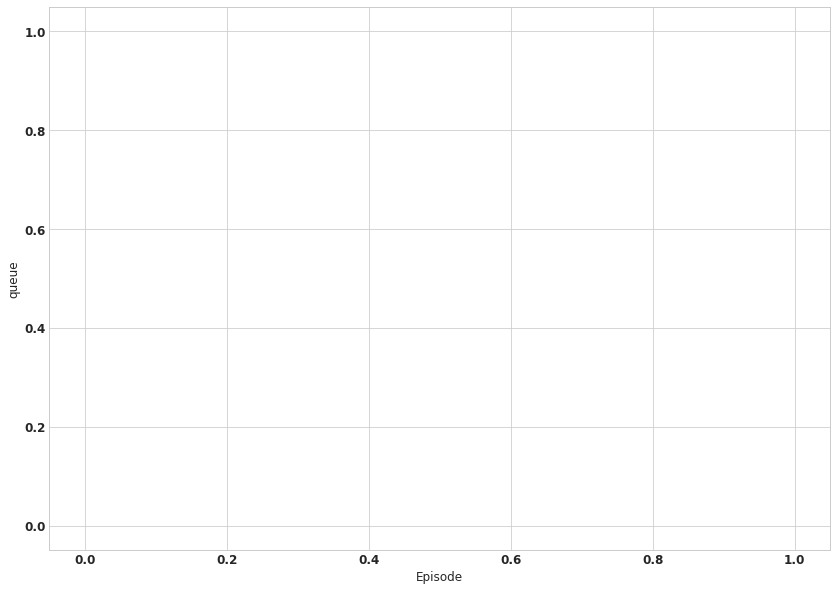

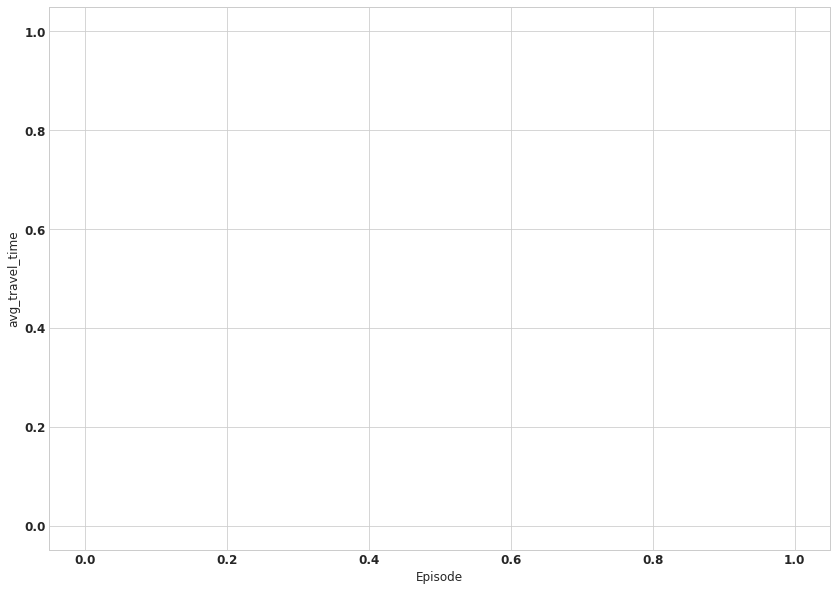

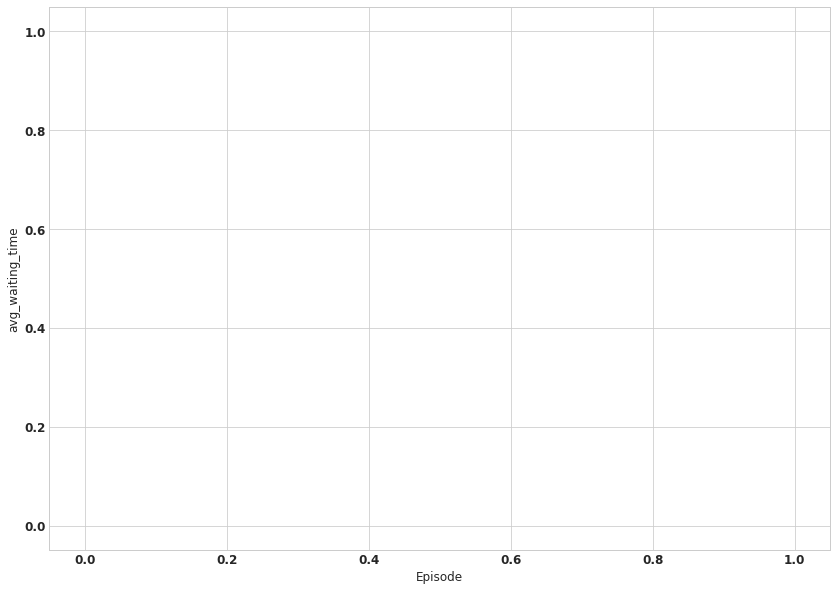

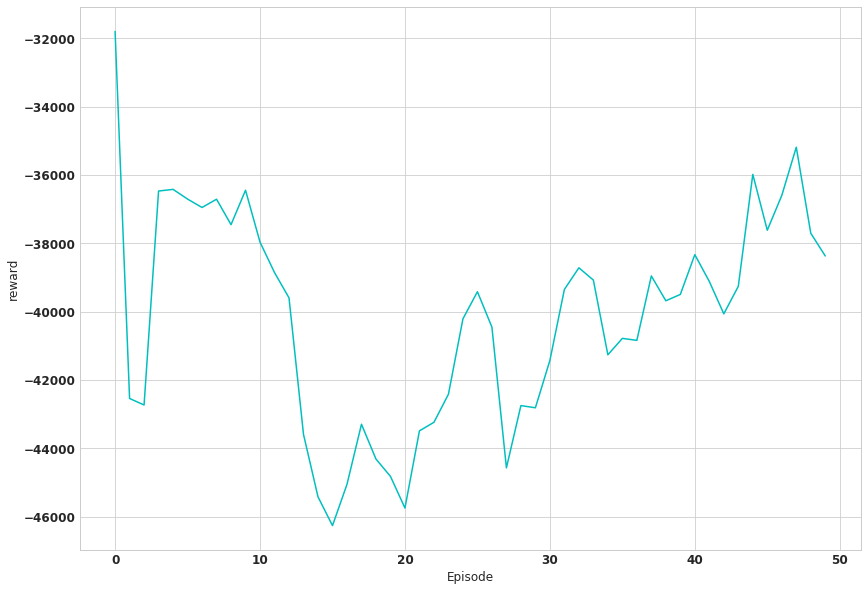

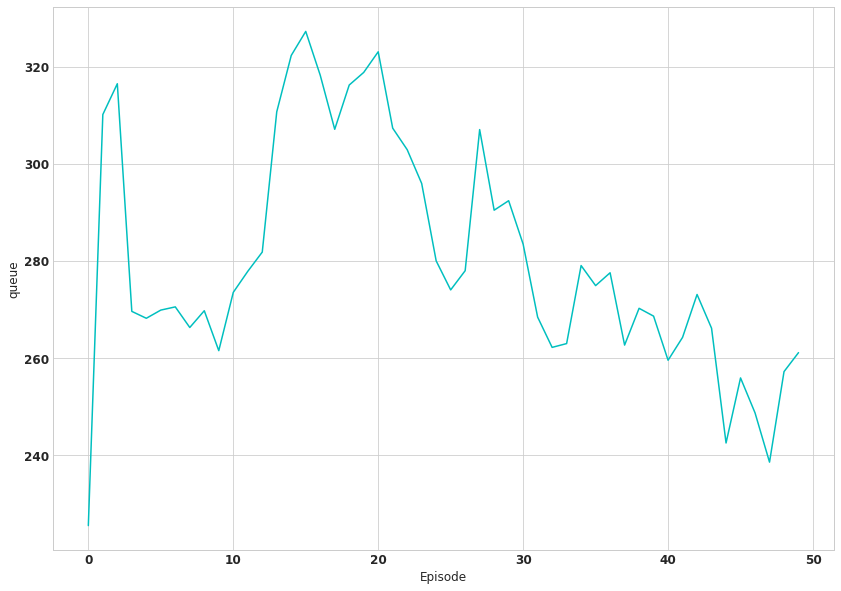

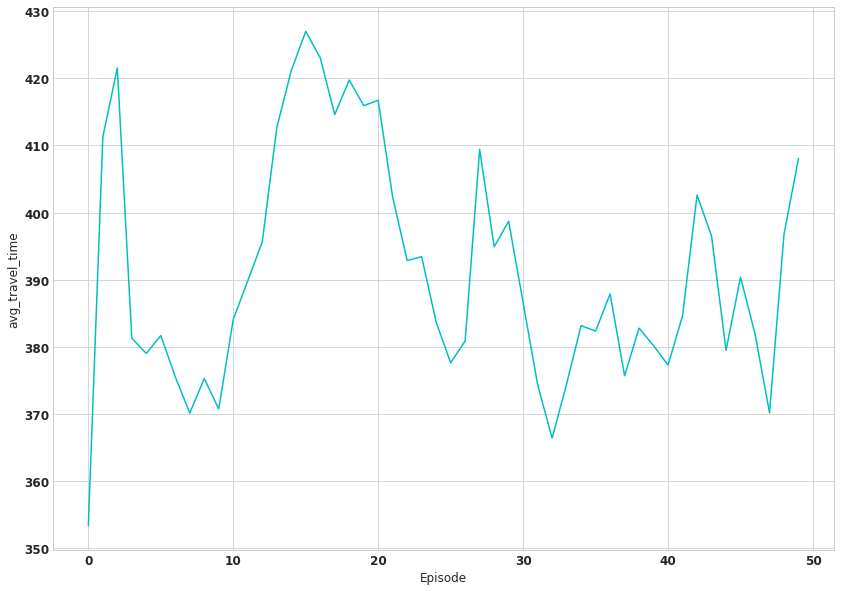

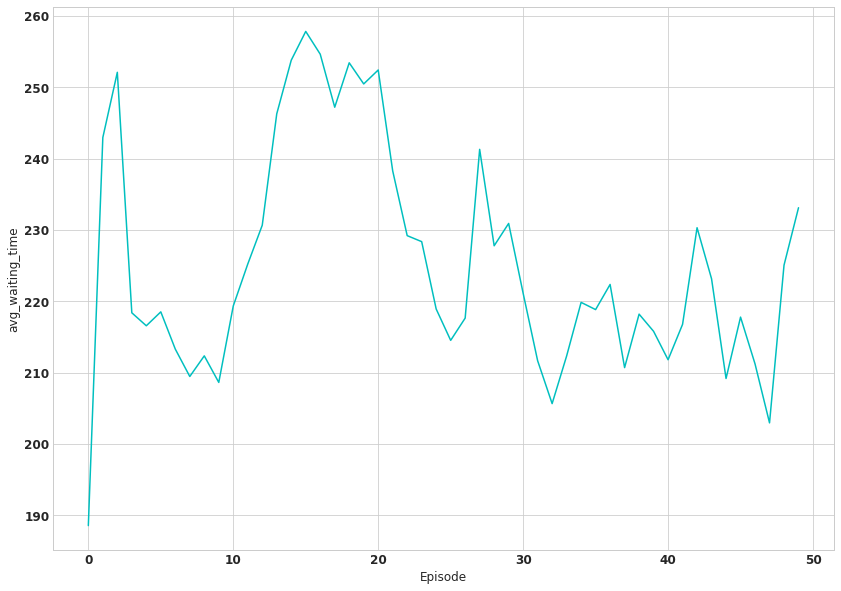

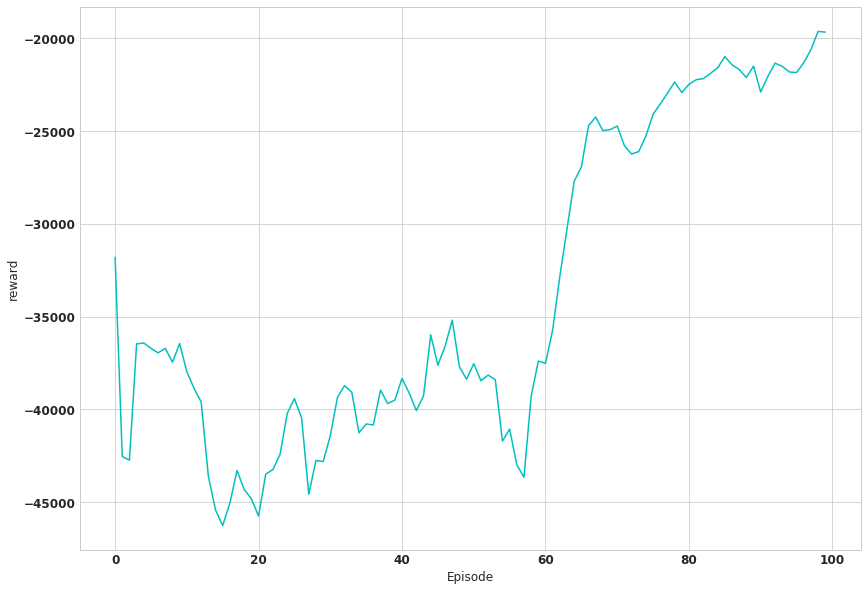

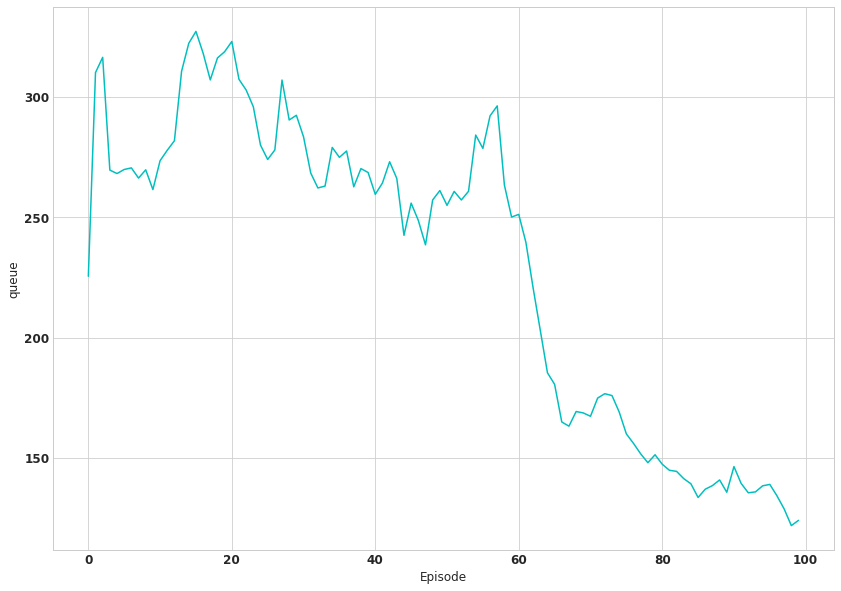

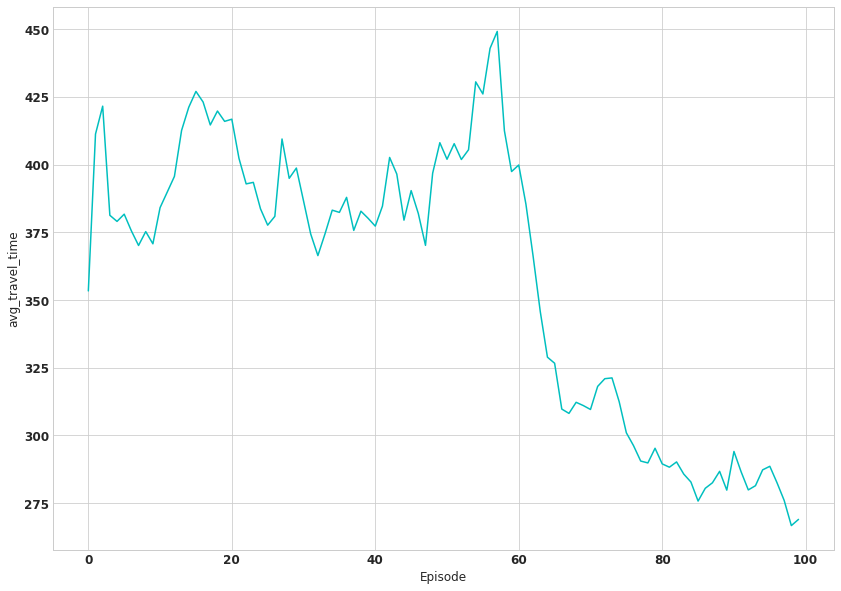

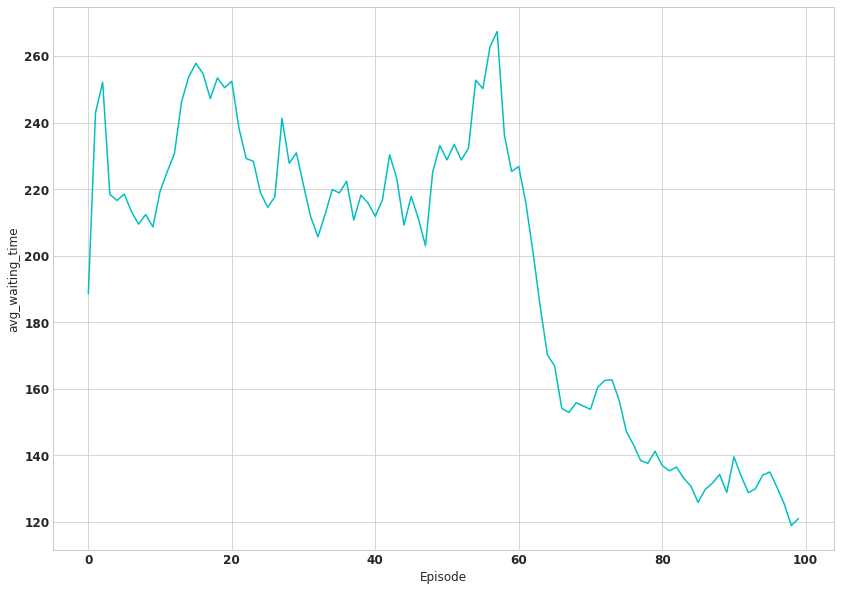

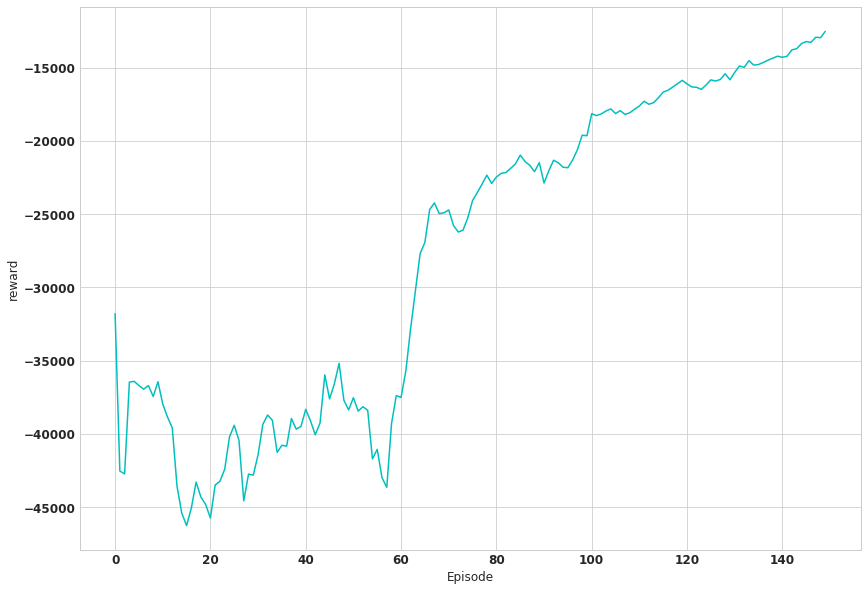

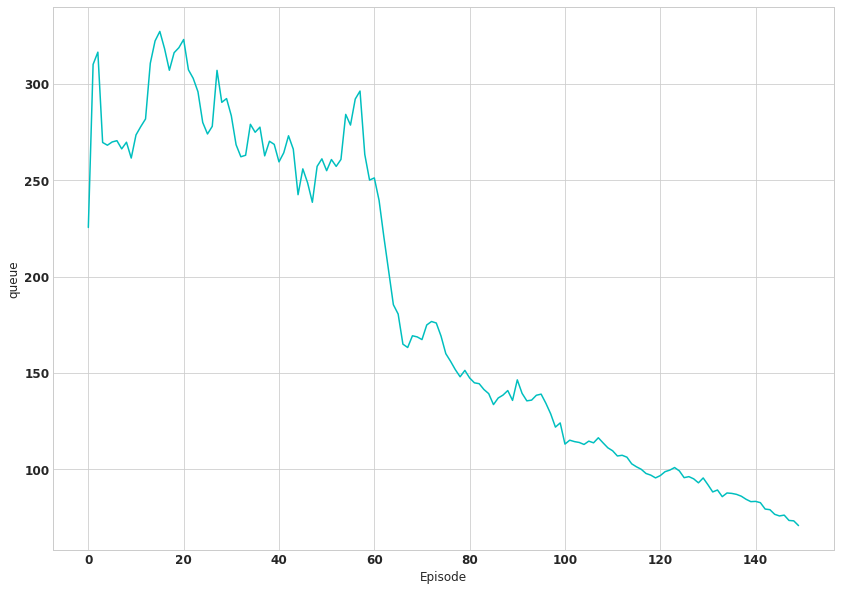

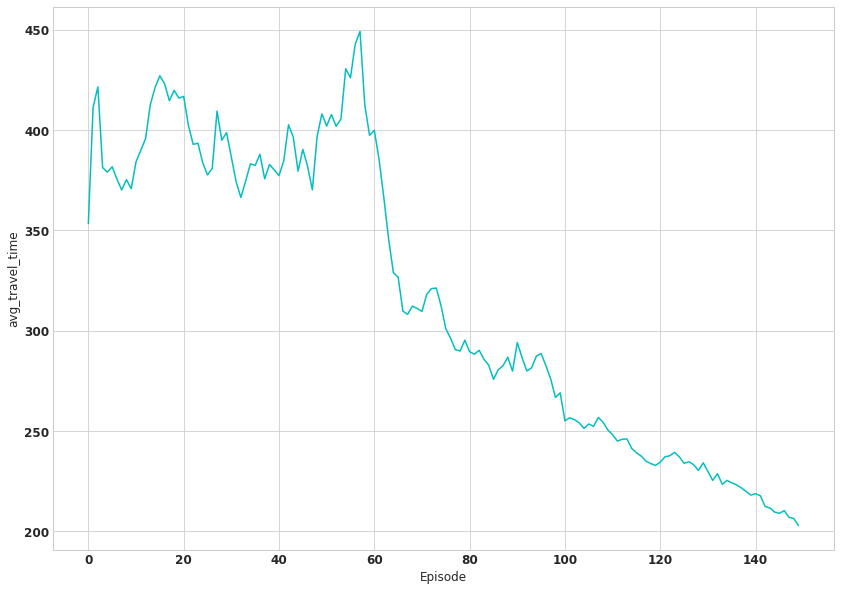

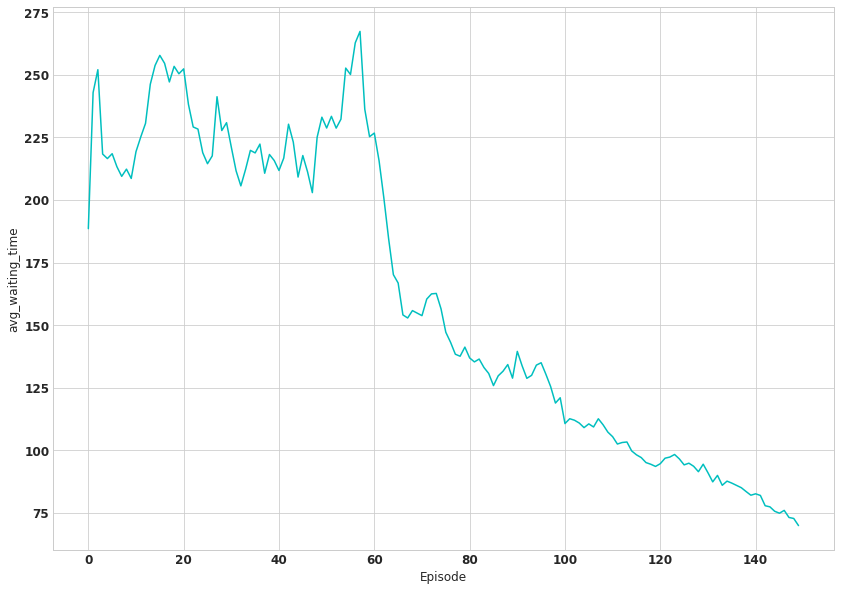

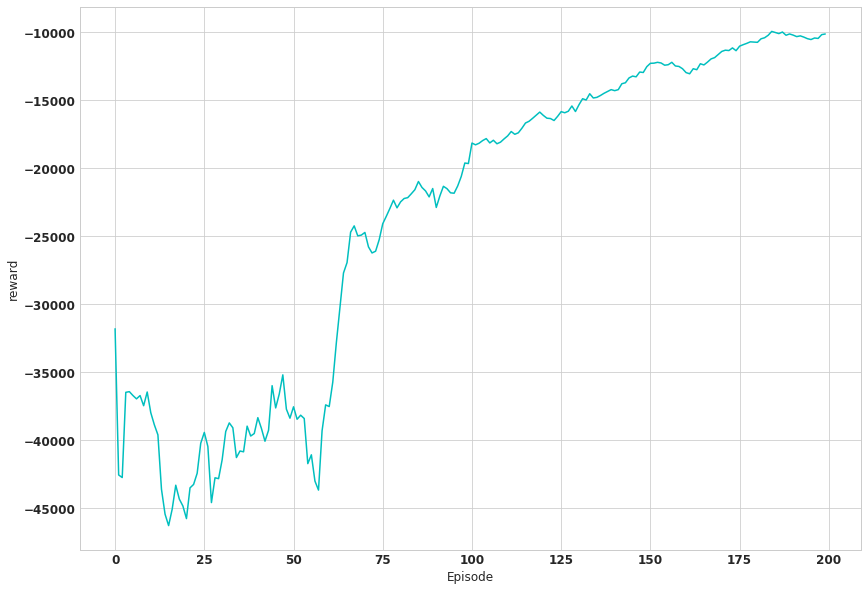

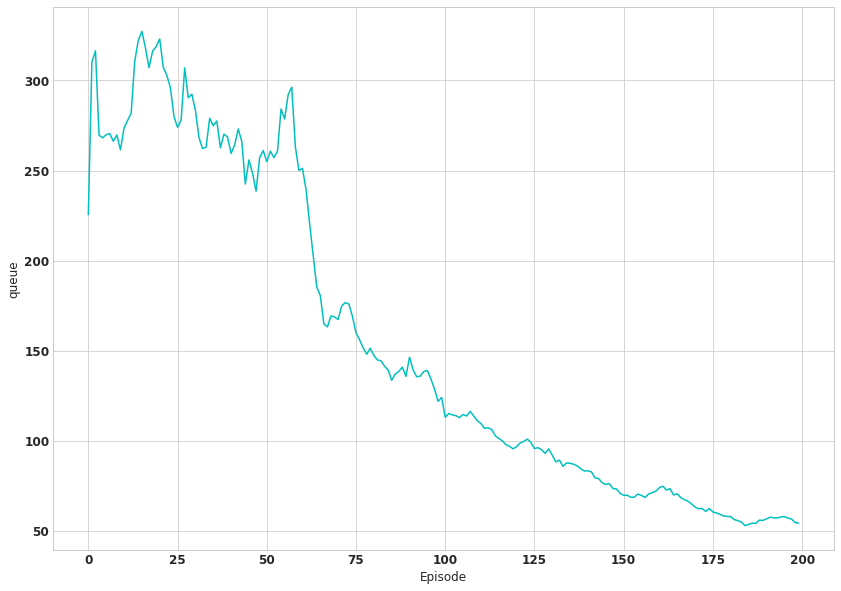

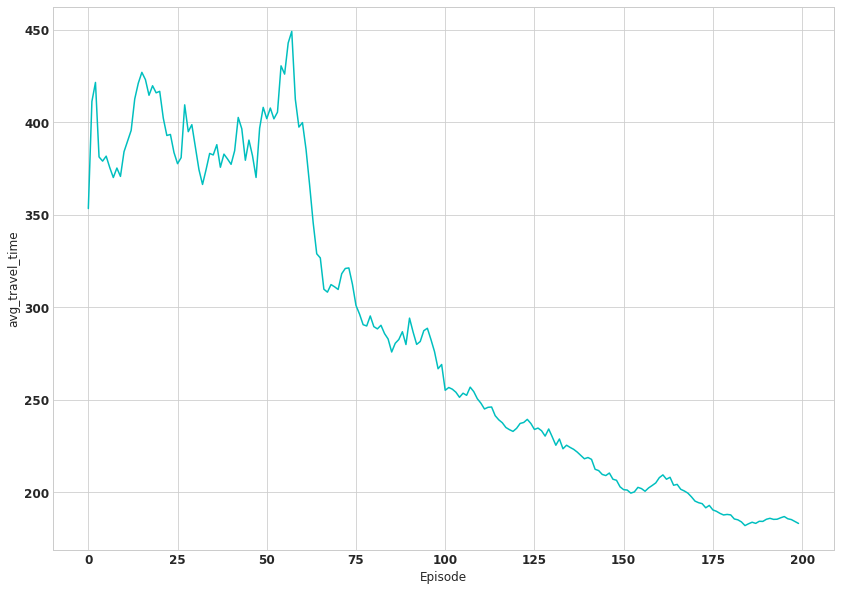

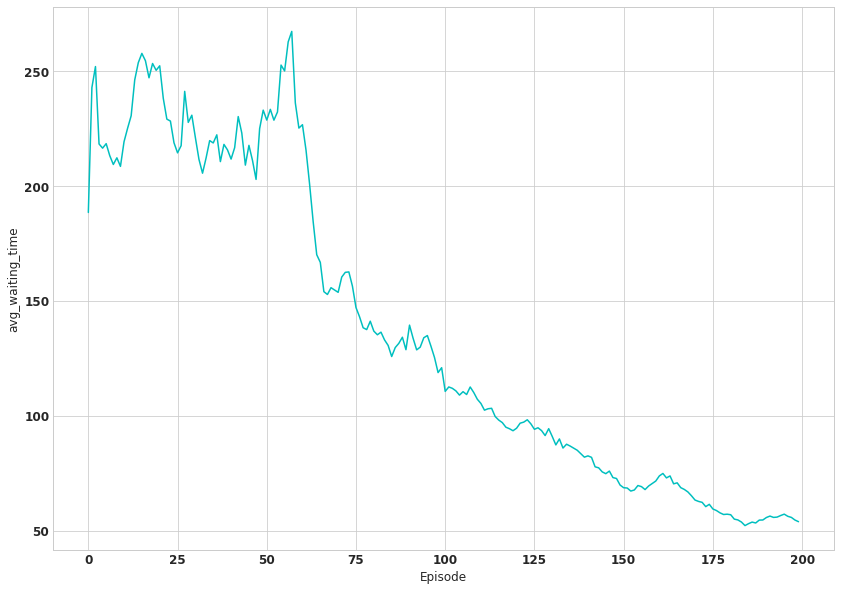

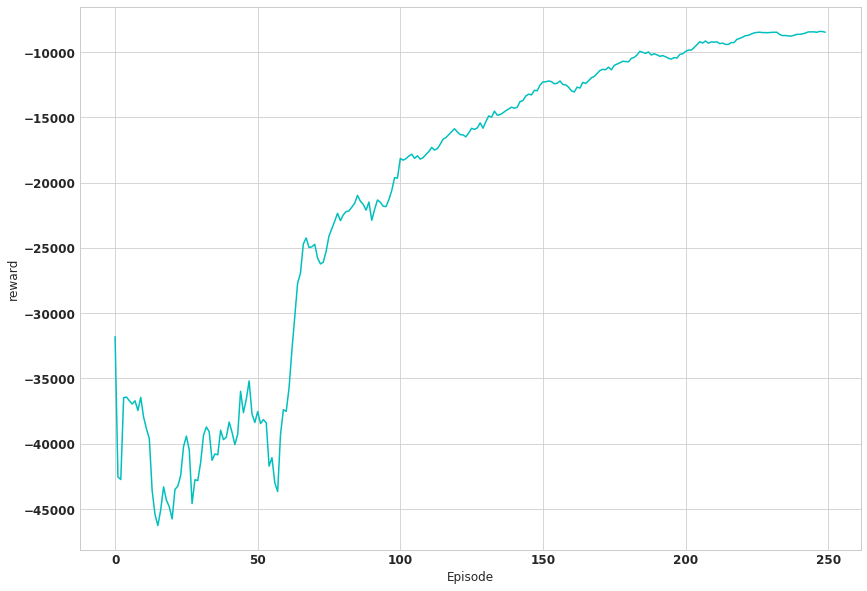

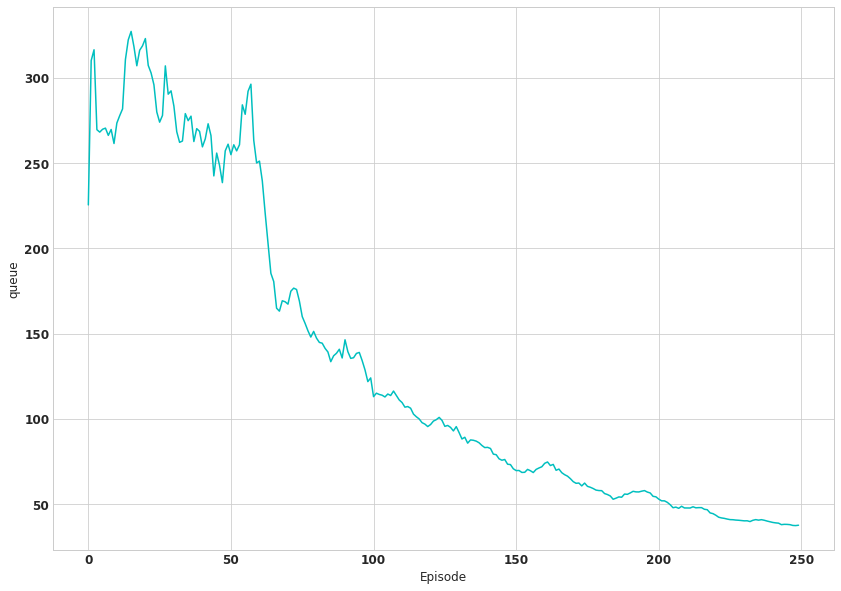

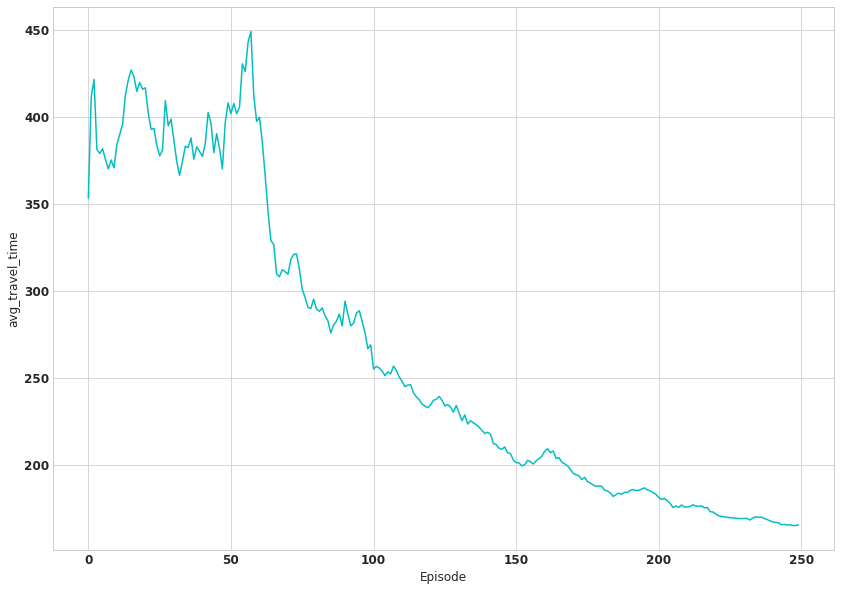

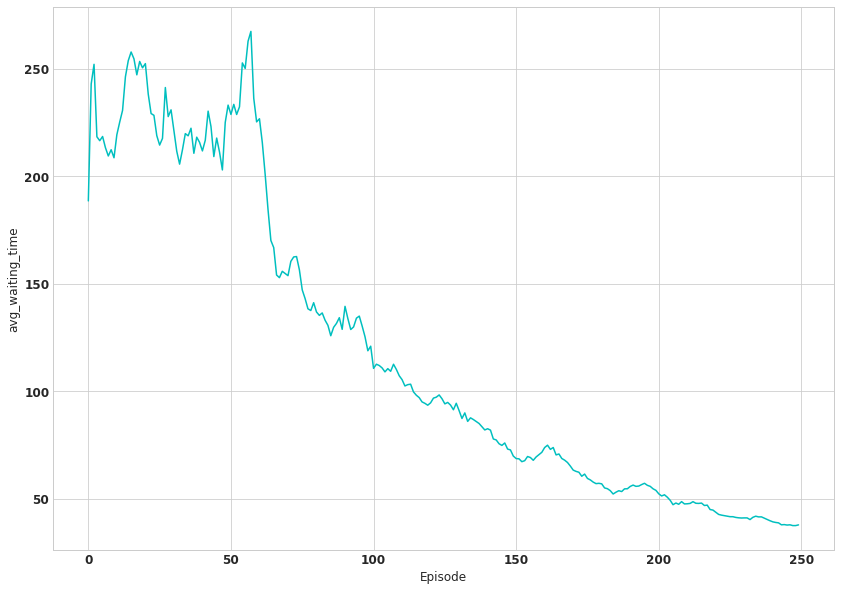

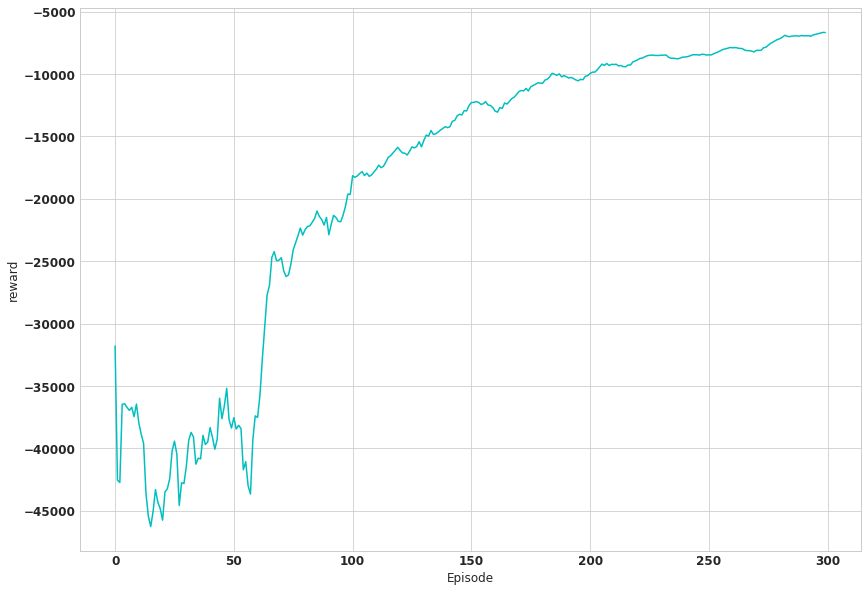

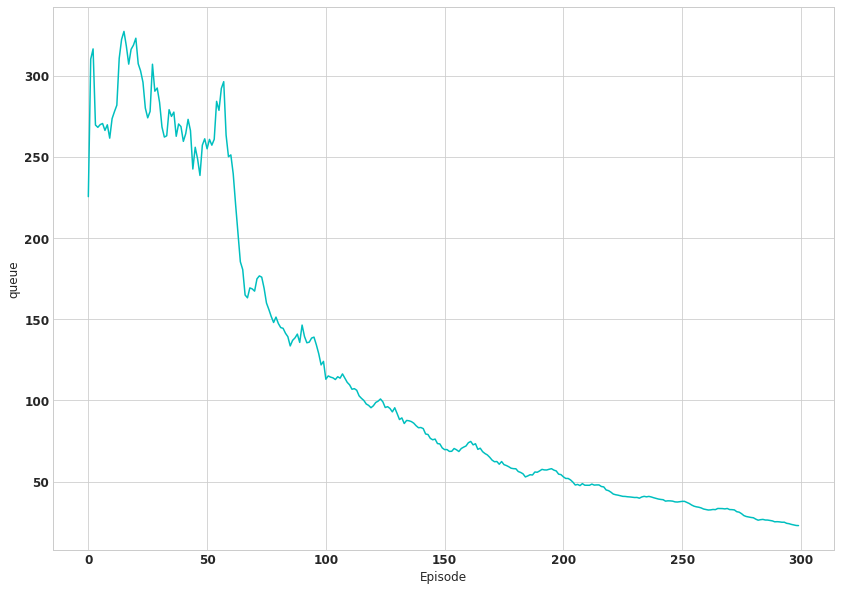

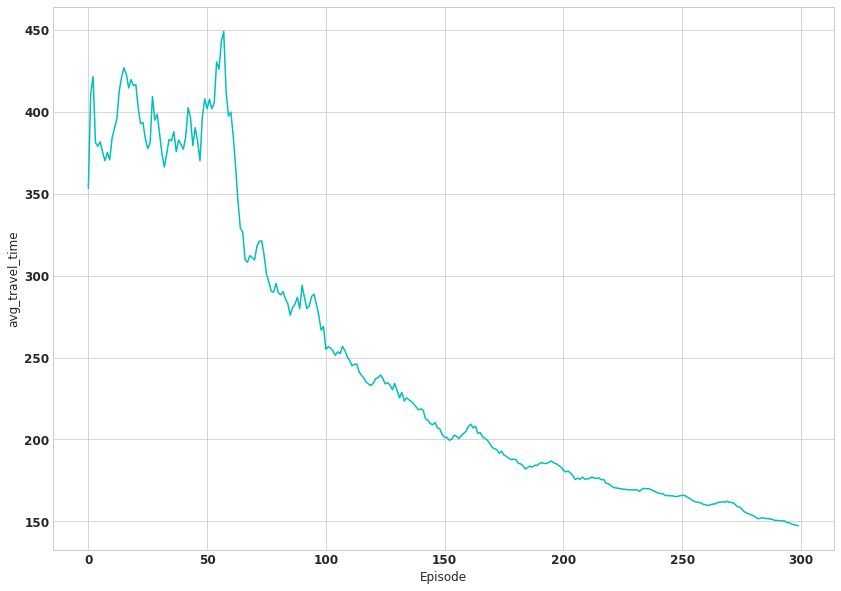

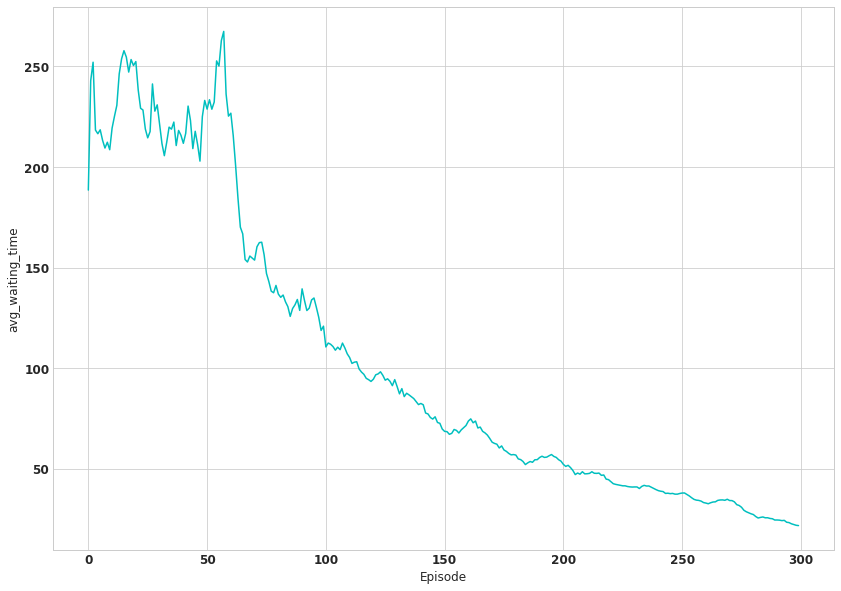

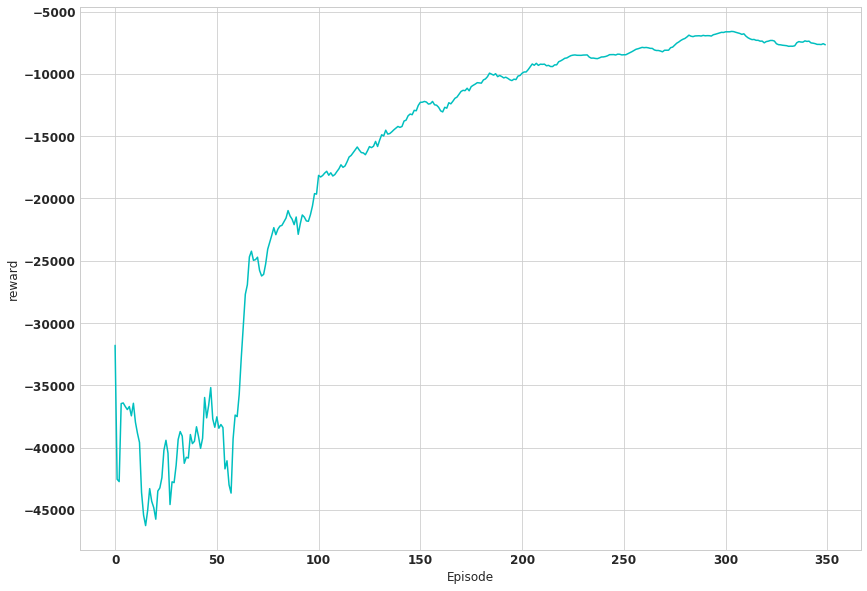

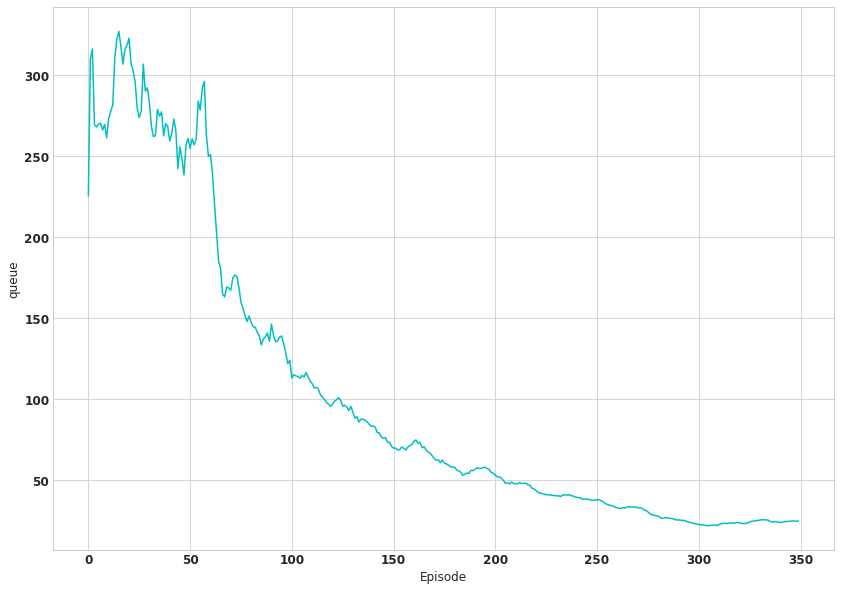

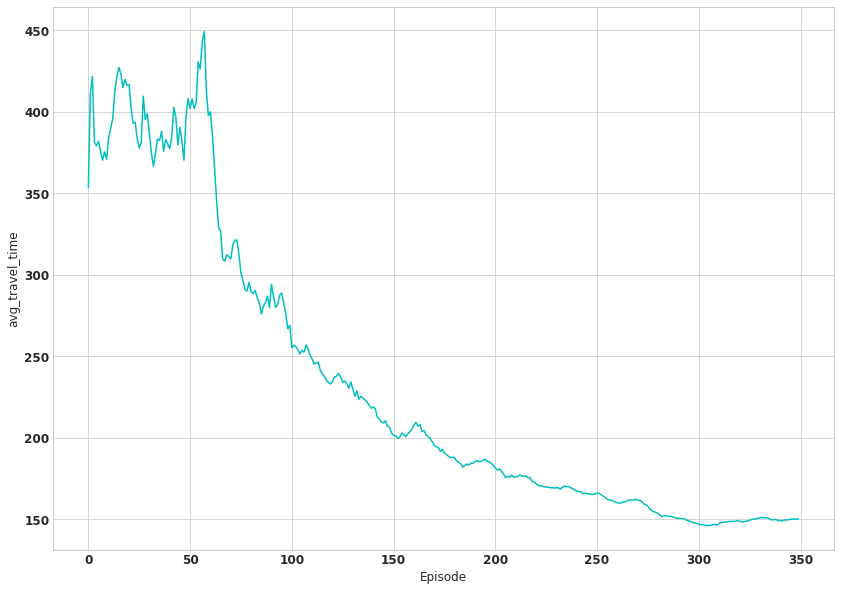

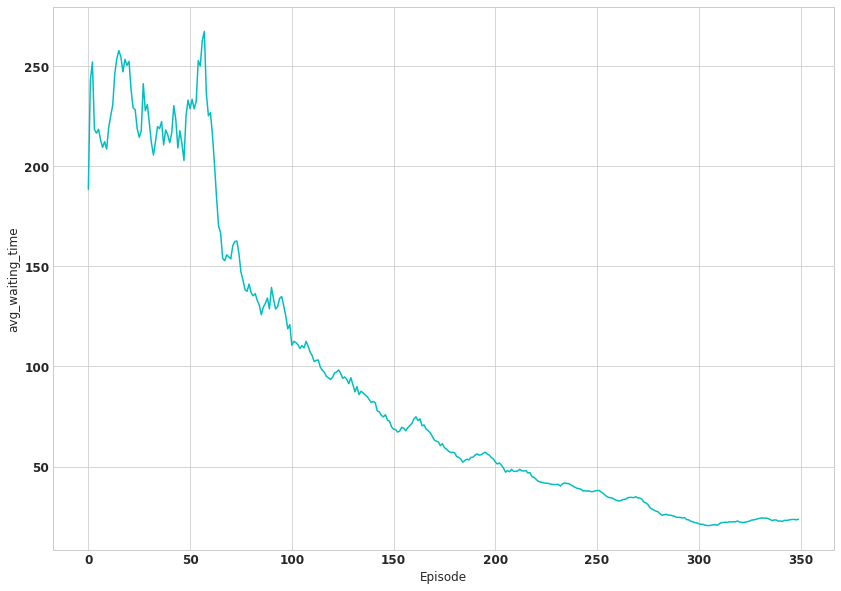

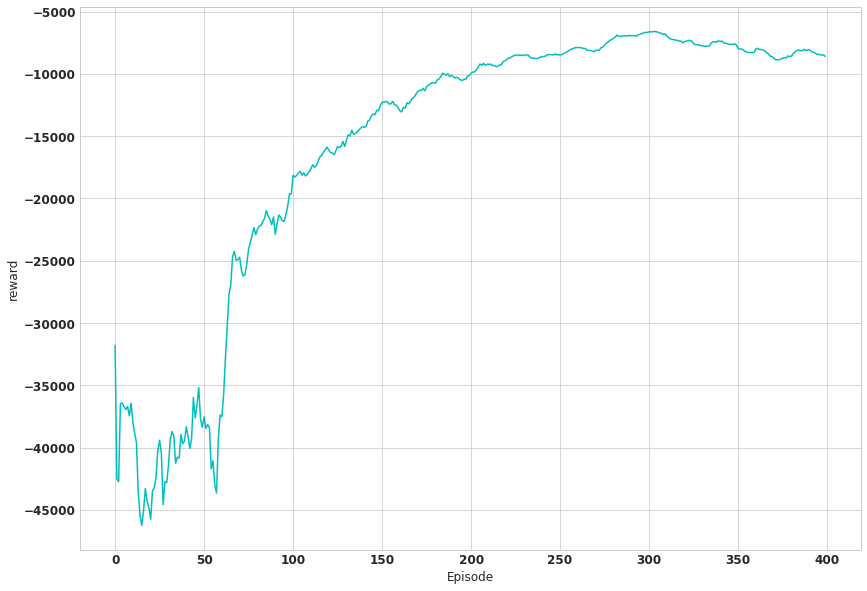

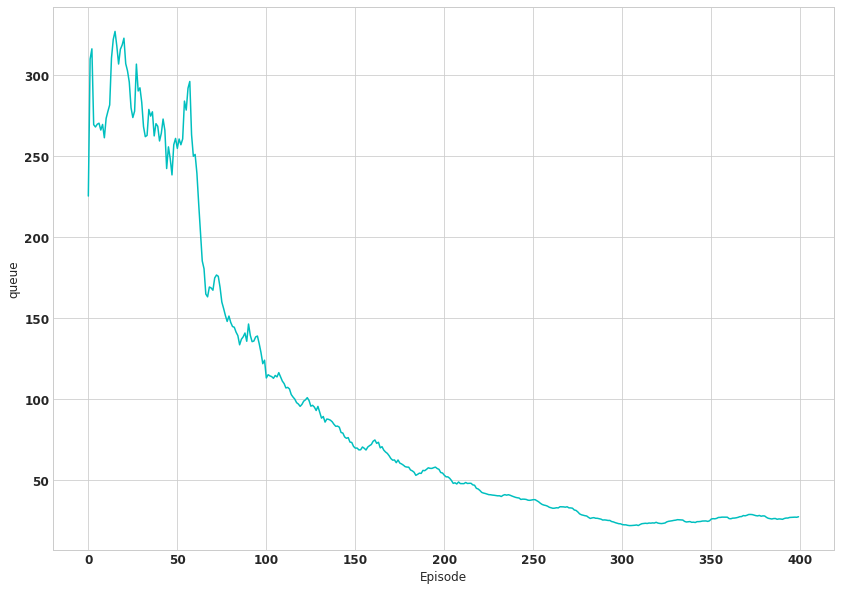

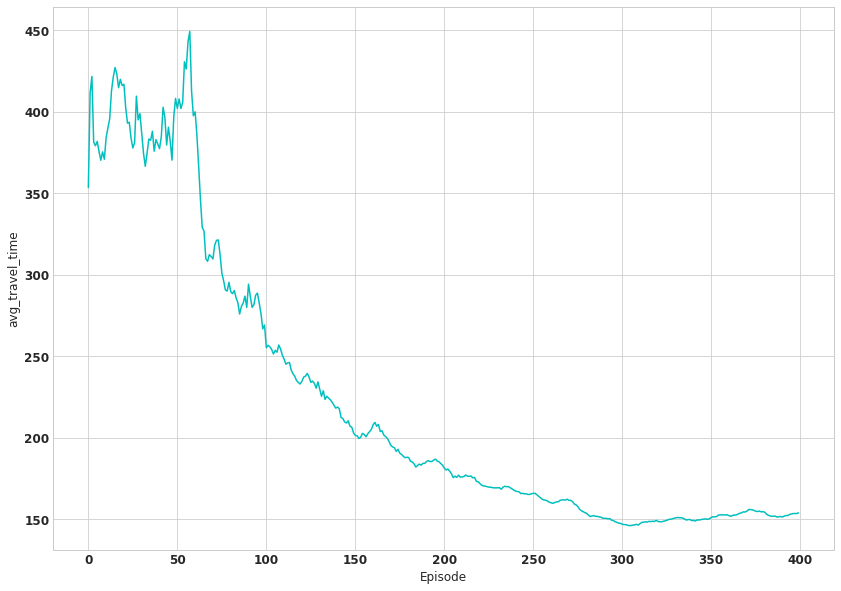

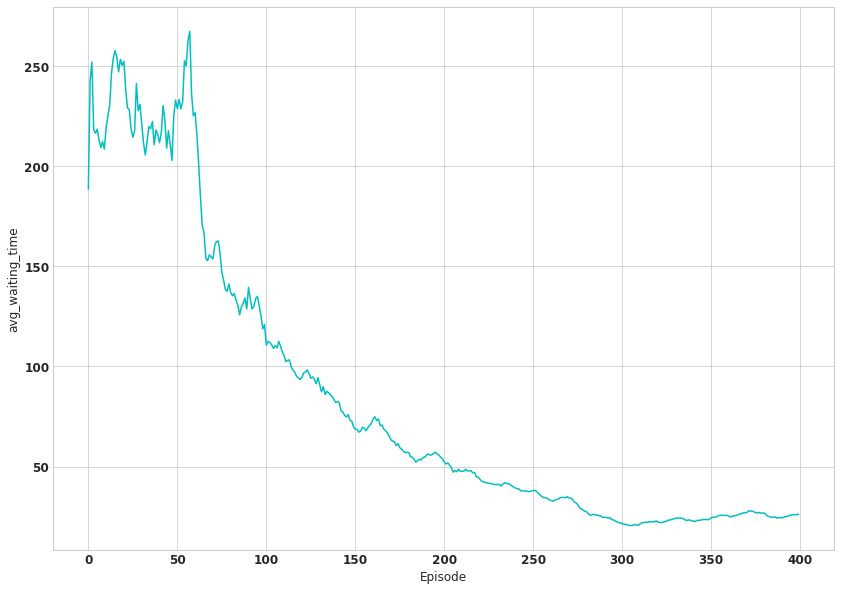

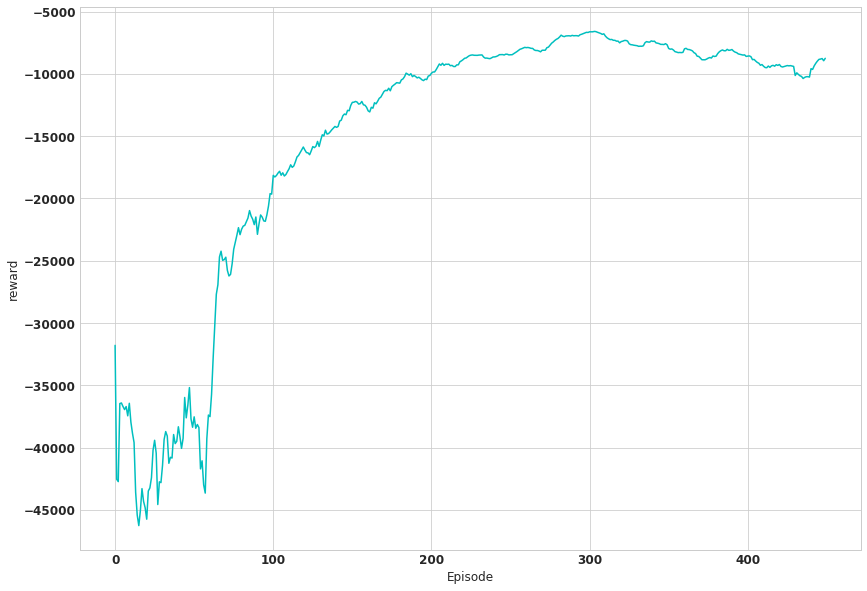

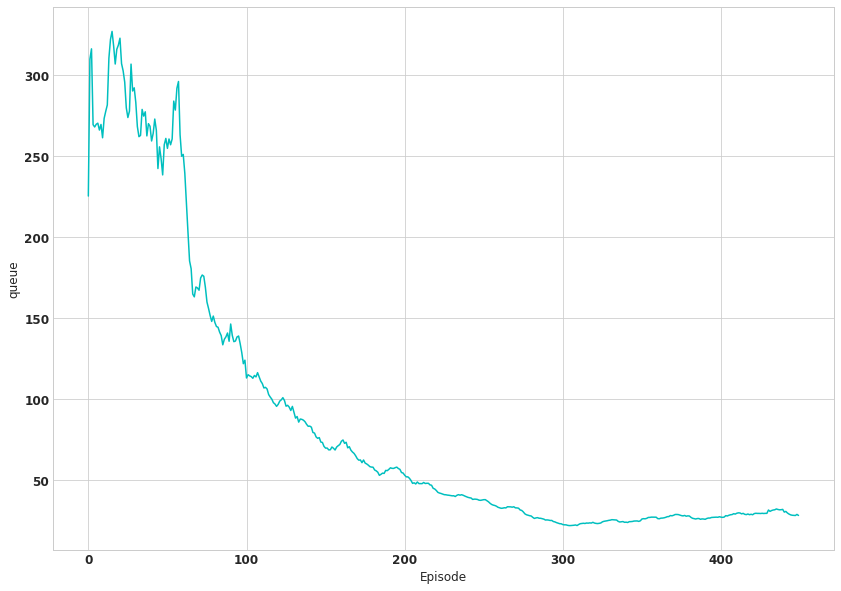

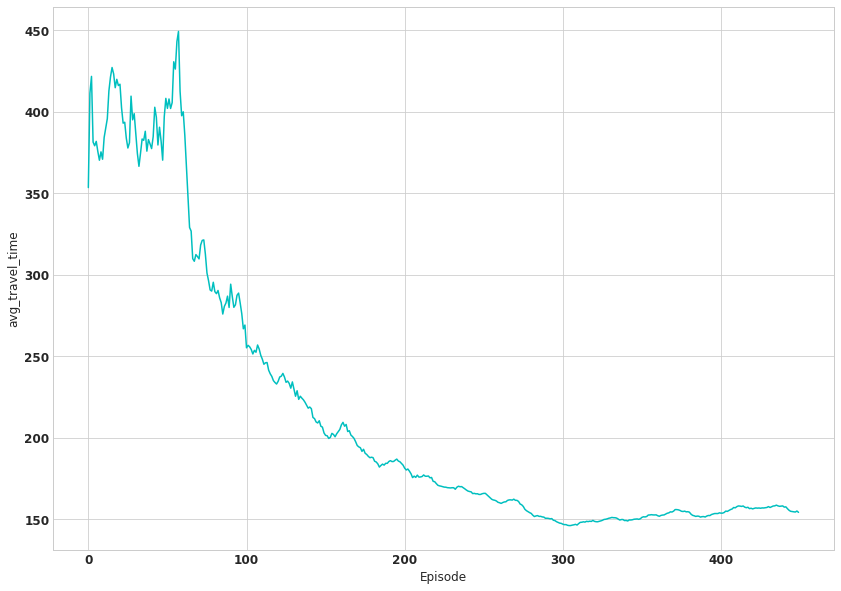

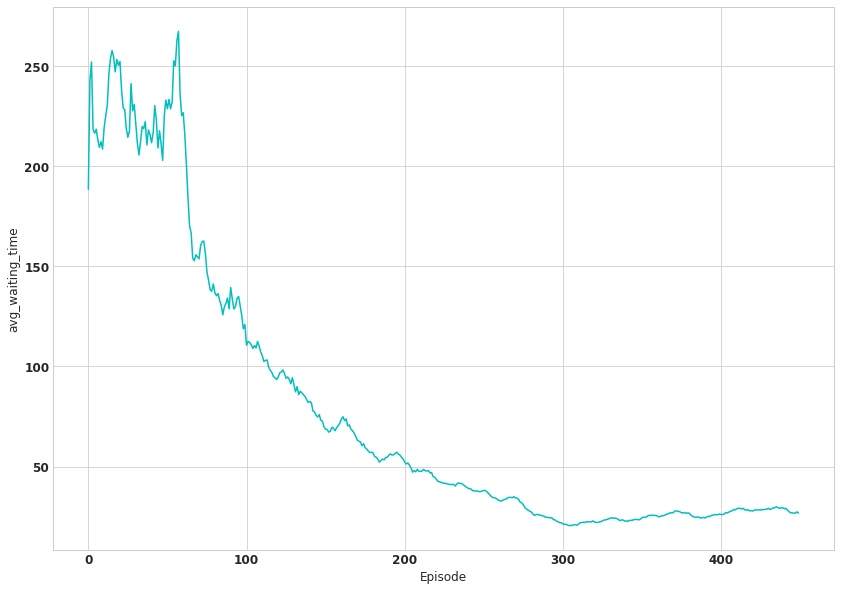

In [13]:
#NEW test 
#TTTEST#Mine
import os
import click
import time
import numpy as np
import gym
import gym_goal
from gym_goal.envs.config import GOAL_WIDTH, PITCH_LENGTH, PITCH_WIDTH
from gym.wrappers import Monitor
from common import ClickPythonLiteralOption
from common.wrappers import ScaledParameterisedActionWrapper
from common.goal_domain import GoalFlattenedActionWrapper, GoalObservationWrapper
from common.wrappers import ScaledStateWrapper
from agents.pdqn import PDQNAgent
from agents.pdqn_split import SplitPDQNAgent
from agents.pdqn_multipass import MultiPassPDQNAgent



def pad_action(act, act_param):
    params = [np.zeros((2,)), np.zeros((1,)), np.zeros((1,))]
    params[act] = act_param
    return (act, params)


def evaluate(env, agent, episodes=1000):
    returns = []
    timesteps = []
    for _ in range(episodes):
        state, _ = env.reset()
        terminal = False
        t = 0
        total_reward = 0.
        while not terminal:
            t += 1
            state = np.array(state, dtype=np.float32, copy=False)
            act, act_param, all_action_parameters = agent.act(state)
            action = pad_action(act, act_param)
            (state, _), reward, terminal, _ = env.step(action)
            total_reward += reward
        timesteps.append(t)
        returns.append(total_reward)
    return np.array(returns)



seed=0
episodes=451
evaluation_episodes=5000
batch_size=64
gamma=0.95
inverting_gradients=True #True ####
           
initial_memory_threshold=128
use_ornstein_noise=False ####
             
replay_memory_size=20000 ###
epsilon_steps=300
epsilon_final=0.01
tau_actor=0.1
tau_actor_param=0.001
learning_rate_actor=0.001 #0.001
learning_rate_actor_param=0.00001 # 0.001 
scale_actions=False#True
initialise_params=False#True#
reward_scale=1./20
clip_grad=1.# 1.
multipass=True#False#

indexed=False#True ####
weighted=False#True ####
average=False# True ####
random_weighted=False#True

split=False#True#
zero_index_gradients=False #False####
layers=(256,)#, 128)
action_input_layer=0
save_freq=0
save_dir="results/goal"
render_freq=100
save_frames=False
visualise=False
title="PDQN"



if save_freq > 0 and save_dir:
    save_dir = os.path.join(save_dir, title + "{}".format(str(seed)))
    os.makedirs(save_dir, exist_ok=True)
assert not (save_frames and visualise)
if visualise:
    assert render_freq > 0
if save_frames:
    assert render_freq > 0
    vidir = os.path.join(save_dir, "frames")
    os.makedirs(vidir, exist_ok=True)


#Action space Wrapper
discrete_space = gym.spaces.Discrete(4)
continuous_space = gym.spaces.Box(np.array([5]), np.array([45]))
action_space = gym.spaces.Tuple((discrete_space, continuous_space))
old_as = action_space 
num_actions = old_as.spaces[0].n

action_space = gym.spaces.Tuple((
            old_as.spaces[0],  # actions
            *(gym.spaces.Box(old_as.spaces[1].low, old_as.spaces[1].high, dtype=np.float32)
              for i in range(0, num_actions))
        ))

#Obs
state_size=17
observation_space = gym.spaces.Box(0 , 50, shape=(state_size,))

# dir = os.path.join(save_dir, title)



np.random.seed(seed)

assert not (split and multipass)

agent_class = PDQNAgent
if split:
    agent_class = SplitPDQNAgent
elif multipass:
    agent_class = MultiPassPDQNAgent
    
# layers_list = [(256,), (256,128,64), (64,64,64)]


agent = agent_class(
                   observation_space=observation_space, #env.observation_space.spaces[0], 
                   action_space=action_space,#env.action_space,
                   batch_size=batch_size,
                   learning_rate_actor= learning_rate_actor,
                   learning_rate_actor_param=learning_rate_actor_param,
                   epsilon_steps=epsilon_steps,
                   epsilon_final=epsilon_final,
                   gamma=gamma,
                   clip_grad=clip_grad,
                   indexed=indexed,
                   average=average,
                   random_weighted=random_weighted,
                   tau_actor=tau_actor,
                   weighted=weighted,
                   tau_actor_param=tau_actor_param,
                   initial_memory_threshold=initial_memory_threshold,
                   use_ornstein_noise=use_ornstein_noise,
                   replay_memory_size=replay_memory_size,
                   inverting_gradients=inverting_gradients,
                   actor_kwargs={'hidden_layers': layers,\
                                 'output_layer_init_std': 1e-5,
                                 'action_input_layer': action_input_layer,},
                   actor_param_kwargs={'hidden_layers': layers, \
                                       'output_layer_init_std': 1e-5,
                                       'squashing_function': False},
                   zero_index_gradients=zero_index_gradients,
                   seed=seed)

if initialise_params:
    agent.set_action_parameter_passthrough_weights(initial_weights, initial_bias)
print(agent)




#######


reward_list = []
queue_list  = []
travel_time_list = []
waiting_time_list = []

AGGREGATE_REWARD_EVERY = 50
start_learning = False

max_steps = 3800
steps = 3800
final_time =3800
save_label = time.ctime()
output_dir = 'tls_model/'
model_path = os.path.join(output_dir, save_label)
if not os.path.exists(model_path):
    os.makedirs(model_path)


# Settings
green_duration = 15
state_type = 'queue' 
flow_type = 'weibull'

n_cars_1 = 4001
n_cars_2 = False
n_cars_3 = False
n_steps_1 = 3600
n_steps_2 = 3600
n_steps_3 = 3600



penalty_type = False
large_action = False
action_size= 4

penalty_type = 'ep_reward'
penalty_type = False
penalty_thresh= -7000
if penalty_type =='teleport':
    del sumoCmd[3:5]

print(sumoCmd)
print('-------------- Setup Training with the Next Parameters --------------')
print('Flow Type:                    |', flow_type)
print('Number of cars generated:     |', str(n_cars))
print('Green Phase duration:         |', green_duration)
print('State and Reward Definition:  |', state_type)
print('Penalty Type:                 |', penalty_type)
print('Multi Pass:                   |', multipass)
print('Layers:                       |', layers)
print('--------------                                        ---------------')


######

total_reward = 0.
returns = []

start_time = time.time()
video_index = 0



for i in range(episodes):
    generate_route_file(dist = 'weibull', n_cars_1=n_cars_1, n_cars_2=n_cars_2,n_cars_3=n_cars_3,\
                                            n_steps_1 = n_steps_1, n_steps_2 = n_steps_2,n_steps_3 = n_steps_3,\
                        episode=i)
    traci.start(sumoCmd)
    intersection = 'intersection'
    traci.simulationStep()
    step = 1

    if save_freq > 0 and save_dir and i % save_freq == 0:
        agent.save_models(os.path.join(save_dir, str(i)))


    old_action = random.randint(0, action_size-1)
    old_phase = old_action
    set_green_phase(old_phase, green_duration=green_duration)
    
    state = get_state(intersection, max_pos=150, state_type=state_type, ignore_far_cars=False)
    state= np.reshape(state, (state_size,))
#     state[-1] = green_duration
    state = np.array(state, dtype=np.float32, copy=False)
    state = state/observation_space.high[0]
    act, act_param, all_action_parameters = agent.act(state)


    episode_reward = 0.
    agent.start_episode()
    terminal = False
    ep_queue_list = []
    old_reward = 0
    for j in range(max_steps):

        
        phase = act
        green_duration = act_param
        green_duration= int(green_duration[0])
        if phase != old_phase:
            set_yellow_phase(old_phase)

        
        
        set_green_phase(phase, green_duration=green_duration)
        step = step + yellow_duration + green_duration

#         print(phase, green_duration)

        next_state = get_state(intersection, state_type=state_type, max_pos=150, ignore_far_cars=False)
        next_state= np.reshape(next_state, (state_size,))


        new_reward = np.sum(next_state[0:-1])
    

        next_state = np.array(next_state, dtype=np.float32, copy=False)
        next_state = next_state/observation_space.high[0]

        
        
        queue = get_queue(intersection)
        reward = - new_reward
        ep_queue_list.append(queue)

        next_step = step + yellow_duration + green_duration
        if next_step >= max_steps:
                    terminal = True




        next_act, next_act_param, next_all_action_parameters = agent.act(next_state)

#         next_action = pad_action(next_act, next_act_param)
        r = reward * reward_scale

        episode_reward += reward

        agent.step(state, (act, all_action_parameters), r, next_state,
                   (next_act, next_all_action_parameters), terminal, step)

        act, act_param, all_action_parameters = next_act, next_act_param, next_all_action_parameters
#         action = next_action
        state = next_state
        old_phase = phase
#         old_reward = reward



        if terminal:
            break
    agent.end_episode()
    ep_queue = sum(ep_queue_list)/len(ep_queue_list)
    queue_list.append(ep_queue)
    reward_list.append(episode_reward)
    average_queue = sum(queue_list[-AGGREGATE_REWARD_EVERY:])/len(queue_list[-AGGREGATE_REWARD_EVERY:])

    returns.append(episode_reward)
    total_reward += episode_reward

    try:
        durations = np.asarray(get_from_info(file_path='intersection_3_info.xml'), dtype=np.float32)
        average_travel_time = np.sum(durations)/len(durations)
        print('avg Travel time: ',average_travel_time)
        travel_time_list.append(average_travel_time)

        waiting_times = np.asarray(get_from_info(file_path='intersection_3_info.xml',\
                                                 retrieve='waitingTime'), dtype=np.float32)
        avg_waiting = np.sum(waiting_times)/len(waiting_times)  
        print('avg waiting time: ',avg_waiting)
        waiting_time_list.append(avg_waiting)

    except:
        print('travel time skipped')
    try:

        durations = np.asarray(get_from_info(), dtype=np.float32)
        avg_duration = np.sum(durations)/len(durations)    
        print('episode :{}/{}, episode_reward {}, avg_queu {}, avg_time:{}'.format(i, episodes, episode_reward, \
                                                                                            ep_queue, avg_duration))

    except:
        print('info file error')

    if np.floor(avg_duration)<=141:
        agent.save_models(model_path+'/'+str(avg_duration)+str(i))
    if i % 50 == 0:

        agent.save_models(model_path+'/'+str(avg_duration)+str(i))
        plot_and_save(reward_list, model_path, 'reward', episode=i)
        plot_and_save(queue_list, model_path, 'queue', episode=i)
        plot_and_save(travel_time_list, model_path, 'avg_travel_time', episode=i)
        plot_and_save(waiting_time_list, model_path, 'avg_waiting_time', episode=i)

    traci.close()
# #     if (i + 1) % 100 == 0:
#     print('{0:5s} R:{1:.5f} P(S):{2:.4f}'.format(str(i + 1), total_reward / (i + 1)    ,
#                                                  returns[i]))
end_time = time.time()
print("Training took %.2f seconds" % (end_time - start_time))
print('average Travel Time:', sum(travel_time_list[-10:])/len(travel_time_list[-10:]))

if save_freq > 0 and save_dir:
    agent.save_models(os.path.join(save_dir, str(i)))










In [ ]:

def test_hybrid_performence(agent, state_type, render=False, n_tests=3, time=4050, naf=False,\
                     green_duration=15,episode=11,  state_size=17,\
                     dist='weibull', both=False, n_cars_1=1501, n_cars_2=4000,n_cars_3=1500, pressure=False,\
                     n_steps_1=3600, n_steps_2=3600, n_steps_3=3600,\
                     ig_far_cars=False, verbose=1, max_pos=250 ):
     '''
    Test the performace of the hybrid agent with different simulation paramters
    '''
    
    average_durations = []
    reward_lists = []
    queue_lists = []
    test_results = []
    
    sumoBinary = 'sumo'

    options = ["--time-to-teleport","-1","--statistic-output","stats.xml", "--eager-insert","True", \
           "--tripinfo-output","intersection_3_info.xml","--summary-output","summary.xml",\
           "--tripinfo-output.write-unfinished","False"]
    
    
    sumoCmd = [sumoBinary,"-c","intersection_3.sumocfg",*options]
#     episode=np.random.randint(1000)
    if agent=='fixed' or both:
        generate_route_file(dist = dist, n_cars_1=n_cars_1, n_cars_2=n_cars_2, n_cars_3=n_cars_3,\
                                n_steps_1 = n_steps_1, n_steps_2 = n_steps_2, n_steps_3 = n_steps_3, episode=episode)
        
        step=0
        intersection = 'intersection'
        avg_durations = []
        queue_list = []
        if render:
                sumoCmd[0] = 'sumo-gui'
        traci.start(sumoCmd)
        while step<time:

            traci.simulationStep()

            queue = get_queue(intersection)
            if step % 18 ==0:
                queue_list.append(queue)

            step = step + 1

        traci.close()
        durations = np.asarray(get_from_info(file_path='intersection_3_info.xml'), dtype=np.float32)
        avg_durations.append(sum(durations)/len(durations))
        print(sum(durations)/len(durations))
        test_results.append(queue_list)
        test_results.append(avg_durations)
        test_results.append(durations)
        if agent=='fixed':
            return test_results
    
    for n in range(n_tests):
#         episode=np.random.randint(1000)
        generate_route_file(dist = dist, n_cars_1=n_cars_1, n_cars_2=n_cars_2, n_cars_3=n_cars_3,\
                                n_steps_1 = n_steps_1, n_steps_2 = n_steps_2, n_steps_3 = n_steps_3, episode=episode)
        
        reward_list= []
        queue_list = []
        if render:
            sumoCmd[0] = 'sumo-gui'

        traci.start(sumoCmd)
        intersection = 'intersection'
        step = 0
        traci.simulationStep()
        if verbose:
            print('.. initialzing the simulation environment')
            
        if state_type == 'DTSE':
            state = get_state_DTSE_2(intersection)
        else:
            state = get_state(intersection, state_type=state_type, max_pos=max_pos)
        
        state = np.reshape(state, [1, state_size])
            
        
        old_action = random.randint(0, action_size-1)
        old_phase = old_action
        set_green_phase(old_phase, green_duration=green_duration)

        state = get_state(intersection, max_pos=150, state_type=state_type, ignore_far_cars=False)
        state= np.reshape(state, (state_size,))
    #     state[-1] = green_duration
        state = np.array(state, dtype=np.float32, copy=False)
        state = state/observation_space.high[0]
        act, act_param, all_action_parameters = agent.act(state)


        episode_reward = 0.
        agent.start_episode()
        terminal = False
        ep_queue_list = []
        old_reward = 0
        
        while step<time:

            
            phase = act
            green_duration = act_param
            green_duration= int(green_duration[0])
            if phase != old_phase:
                set_yellow_phase(old_phase)
            

            
            set_green_phase(phase, green_duration=green_duration)
            step = step + yellow_duration + green_duration


            
            next_state = get_state(intersection, state_type=state_type, max_pos=150, ignore_far_cars=False)
            next_state= np.reshape(next_state, (state_size,))
    #         next_state[-1] = green_duration
            new_reward = np.sum(next_state[0:-1])

            next_state = np.array(next_state, dtype=np.float32, copy=False)
            next_state = next_state/observation_space.high[0]
            

            queue = get_queue(intersection)
            queue_list.append(queue)
            reward_list.append(new_reward)
            next_act, next_act_param, next_all_action_parameters = agent.act(next_state)
            act, act_param, all_action_parameters = next_act, next_act_param, next_all_action_parameters

            state = next_state
            old_phase = phase
            
        
        traci.close()
        #for every test append
        reward_lists.append(reward_list)
        queue_lists.append(queue_list)
        durations = np.asarray(get_from_info(file_path='intersection_3_info.xml'), dtype=np.float32)
        average_durations.append(sum(durations)/len(durations))
        
        print(sum(durations)/len(durations))
    if both:
        return reward_lists, queue_lists, average_durations, durations, test_results
    else:
        return reward_lists, queue_lists, average_durations, durations



In [ ]:
#Testing Perfrmance / change model path to the saved model directory
model_path = 'tls_model/saved_model'
agent.load_models(model_path+'/141.73045420699927300')
agent.epsilon = 0.




n_cars_1 = 4001
n_cars_2 = False#4000
n_cars_3 = False#1500
n_steps_1 = 3800
n_steps_2 = 3600
n_steps_3 = 3600
state_type = 'queue'
state_size = 17
flow_type = 'weibull'
total_time = 3800 #+ 3600*2 
green_duration = 15

avg=[]
rand_eps = [70, 950, 495, 823, 113, 148, 732, 876, 518, 517]
for episode in rand_eps:
    
    rs, qs, avg_dur, durations = test_hybrid_performence(agent, state_type, render=False, n_tests=1, time=total_time,\
                         green_duration=green_duration, episode=episode,  state_size=state_size, dist=flow_type,\
                          both=False, n_cars_1=n_cars_1, n_cars_2=n_cars_2,n_cars_3=n_cars_3, pressure=False,\
                         n_steps_1=3600, n_steps_2=3600, n_steps_3=3600,\
                         ig_far_cars=False, verbose=0, max_pos=250)
    avg.append(np.squeeze(avg_dur))
print('avg dur:',np.mean(avg))



